In [ ]:
# https://github.com/sudoaditya/Handwritten-Text-Recognition/blob/master/Notebook/Building_NN_with_IAM_Words.ipynb

## Run this bash command once.

In [ ]:
!wget -q https://github.com/sayakpaul/Handwriting-Recognizer-in-Keras/releases/download/v1.0.0/IAM_Words.zip

In [ ]:
!unzip -qq IAM_Words.zip

In [ ]:
!mkdir -p data/words

In [ ]:
!tar -xf IAM_Words/words.tgz -C data/words

In [ ]:
!mv IAM_Words/words.txt data

In [ ]:
!rm -rf IAM_Words

In [ ]:
!rm IAM_Words.zip

In [ ]:
!sed -i "1, 18d" data/words.txt

In [ ]:
!cat data/words.txt | head

a01-000u-00-00 ok 154 408 768 27 51 AT A
a01-000u-00-01 ok 154 507 766 213 48 NN MOVE
a01-000u-00-02 ok 154 796 764 70 50 TO to
a01-000u-00-03 ok 154 919 757 166 78 VB stop
a01-000u-00-04 ok 154 1185 754 126 61 NPT Mr.
a01-000u-00-05 ok 154 1438 746 382 73 NP Gaitskell
a01-000u-00-06 ok 154 1896 757 173 72 IN from
a01-000u-01-00 ok 156 395 932 441 100 VBG nominating
a01-000u-01-01 ok 156 901 958 147 79 DTI any
a01-000u-01-02 ok 156 1112 958 208 42 AP more


## Import Libraries

In [ ]:
!pip install keras-tqdm

In [ ]:
import numpy as np
import cv2
import os
import pandas as pd
import string
import matplotlib.pyplot as plt

from keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras_tqdm import TQDMNotebookCallback

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf

## Load Dataset

In [ ]:
with open('./data/words.txt') as f:
    contents = f.readlines()

lines = [line.strip() for line in contents]
lines[0]

'a01-000u-00-00 ok 154 408 768 27 51 AT A'

In [ ]:
max_label_len = 0

char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

# string.ascii_letters + string.digits (Chars & Digits)
# or
# "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

print(char_list, len(char_list))

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, chara in enumerate(txt):
        dig_lst.append(char_list.index(chara))

    return dig_lst


!"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz 78


In [ ]:
images = []
labels = []

RECORDS_COUNT = 10000


In [ ]:
train_images = []
train_labels = []
train_input_length = []
train_label_length = []
train_original_text = []

valid_images = []
valid_labels = []
valid_input_length = []
valid_label_length = []
valid_original_text = []

inputs_length = []
labels_length = []

# Image Processing

In [ ]:
def process_image(img):
    """
    Converts image to shape (32, 128, 1) & normalize
    """
    w, h = img.shape

    # Aspect Ratio Calculation
    new_w = 32
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h = img.shape

    img = img.astype('float32')

    # Converts each to (32, 128, 1)
    if w < 32:
        add_zeros = np.full((32-w, h), 255)
        img = np.concatenate((img, add_zeros))
        w, h = img.shape

    if h < 128:
        add_zeros = np.full((w, 128-h), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h = img.shape

    if h > 128 or w > 32:
        dim = (128,32)
        img = cv2.resize(img, dim)

    img = cv2.subtract(255, img)

    img = np.expand_dims(img, axis=2)

    # Normalize
    img = img / 255

    return img


##  Generate train & validation set


In [ ]:
import numpy as np

# Initialize empty lists for train and valid data
#train_images, train_labels, train_input_length, train_label_length, train_original_text = [], [], [], [], []
#valid_images, valid_labels, valid_input_length, valid_label_length, valid_original_text = [], [], [], [], []

# Initialize max_label_len
max_label_len = 0

for index, line in enumerate(lines):
    splits = line.split(' ')
    status = splits[1]

    if status == 'ok':
        word_id = splits[0]
        word = "".join(splits[8:])

        splits_id = word_id.split('-')
        filepath = './data/words/{}/{}-{}/{}.png'.format(splits_id[0],
                                                  splits_id[0],
                                                  splits_id[1],
                                                  word_id)

        # process image
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        try:
            img = process_image(img)
        except:
            continue

        # process label
        try:
            label = encode_to_labels(word)
        except:
            continue

        if index % 10 == 0:
            valid_images.append(img)
            valid_labels.append(label)
            valid_input_length.append(31)
            valid_label_length.append(len(word))
            valid_original_text.append(word)
        else:
            train_images.append(img)
            train_labels.append(label)
            train_input_length.append(31)
            train_label_length.append(len(word))
            train_original_text.append(word)

        if len(word) > max_label_len:
            max_label_len = len(word)

    if index >= RECORDS_COUNT:
        break

# Convert lists to NumPy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)
train_input_length = np.array(train_input_length)
train_label_length = np.array(train_label_length)
train_original_text = np.array(train_original_text)

valid_images = np.array(valid_images)
valid_labels = np.array(valid_labels)
valid_input_length = np.array(valid_input_length)
valid_label_length = np.array(valid_label_length)
valid_original_text = np.array(valid_original_text)


<ipython-input-18-be76c57dba61>:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_labels = np.array(train_labels)
<ipython-input-18-be76c57dba61>:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  valid_labels = np.array(valid_labels)


In [ ]:
train_padded_label = pad_sequences(train_labels,
                             maxlen=max_label_len,
                             padding='post',
                             value=len(char_list))

valid_padded_label = pad_sequences(valid_labels,
                             maxlen=max_label_len,
                             padding='post',
                             value=len(char_list))

In [ ]:
train_padded_label.shape, valid_padded_label.shape

((7850, 16), (876, 16))

((7850, 16), (876, 16))

##  Converts to Numpy array

In [ ]:
train_images = np.asarray(train_images)
train_input_length = np.asarray(train_input_length)
train_label_length = np.asarray(train_label_length)

valid_images = np.asarray(valid_images)
valid_input_length = np.asarray(valid_input_length)
valid_label_length = np.asarray(valid_label_length)

In [ ]:
train_images.shape

(7850, 32, 128, 1)

## Build Model
Convolutional Recurrent Neural Network

In [ ]:
# input with shape of height=32 and width=128
inputs = Input(shape=(32,128,1))

# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)

conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)

conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)

conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)

conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)

conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)

squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)

# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(blstm_1)

outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

In [ ]:
act_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 128, 1)]      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 128, 64)       640       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 16, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 64, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 8, 32, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 32, 256)        2951

In [ ]:
the_labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args

    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)

In [ ]:
batch_size = 8
# epochs = 60
epochs = 30
e = str(epochs)
optimizer_name = 'adam'

In [ ]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = optimizer_name, metrics=['accuracy'])

filepath="{}o-{}r-{}e-{}t-{}v.hdf5".format(optimizer_name,
                                          str(RECORDS_COUNT),
                                          str(epochs),
                                          str(train_images.shape[0]),
                                          str(valid_images.shape[0]))

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [ ]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

## Run Model

In [ ]:
history = model.fit(x=[train_images, train_padded_label, train_input_length, train_label_length],
                    y=np.zeros(len(train_images)),
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=([valid_images, valid_padded_label, valid_input_length, valid_label_length], [np.zeros(len(valid_images))]),
                    verbose=1,callbacks=callbacks_list)

Epoch 1/30
981/982 [============================>.] - ETA: 0s - loss: 14.1246 - accuracy: 0.0183
Epoch 1: val_loss improved from inf to 13.22126, saving model to adamo-10000r-30e-7850t-876v.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


982/982 [==============================] - 42s 33ms/step - loss: 14.1235 - accuracy: 0.0183 - val_loss: 13.2213 - val_accuracy: 0.0183
Epoch 2/30
980/982 [============================>.] - ETA: 0s - loss: 11.8879 - accuracy: 0.0514
Epoch 2: val_loss improved from 13.22126 to 11.72636, saving model to adamo-10000r-30e-7850t-876v.hdf5
982/982 [==============================] - 29s 30ms/step - loss: 11.8807 - accuracy: 0.0516 - val_loss: 11.7264 - val_accuracy: 0.0674
Epoch 3/30
981/982 [============================>.] - ETA: 0s - loss: 10.4993 - accuracy: 0.0728
Epoch 3: val_loss improved from 11.72636 to 10.08585, saving model to adamo-10000r-30e-7850t-876v.hdf5
982/982 [==============================] - 31s 32ms/step - loss: 10.4998 - accuracy: 0.0727 - val_loss: 10.0858 - val_accuracy: 0.0765
Epoch 4/30
981/982 [============================>.] - ETA: 0s - loss: 9.5262 - accuracy: 0.0958
Epoch 4: val_loss improved from 10.08585 to 9.42416, saving model to adamo-10000r-30e-7850t-876v.hd

## Training Accuracy

### Prediction 1

7/7 [==============================] - 0s 22ms/step
0riginal text =   not
Predicted text = not

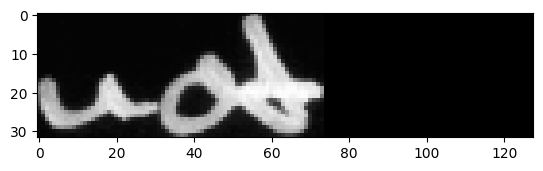



0riginal text =   personal
Predicted text = persorat

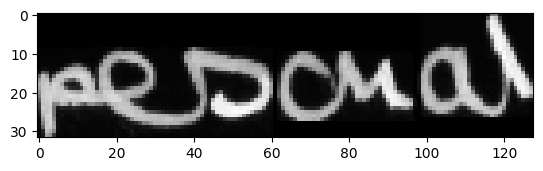



0riginal text =   talks
Predicted text = talks

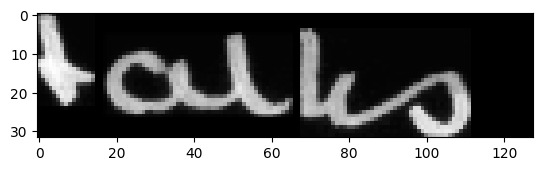



0riginal text =   with
Predicted text = with

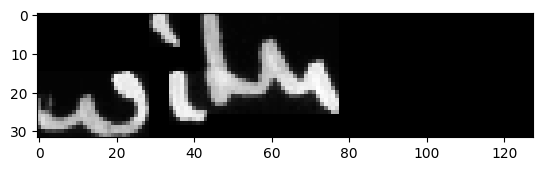



0riginal text =   Dr.
Predicted text = Drr.

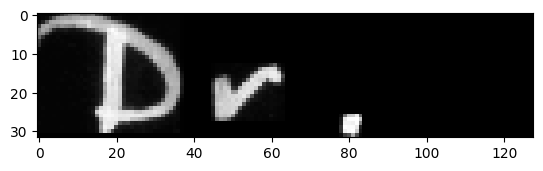



0riginal text =   Adenauer
Predicted text = Adenouer

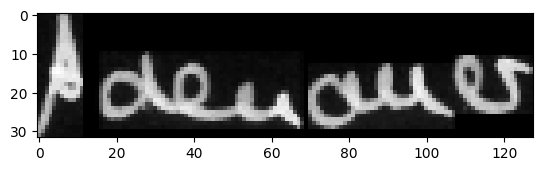



0riginal text =   ,
Predicted text = ,

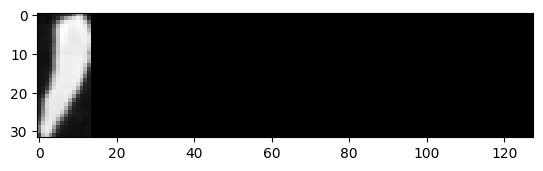



0riginal text =   the
Predicted text = the

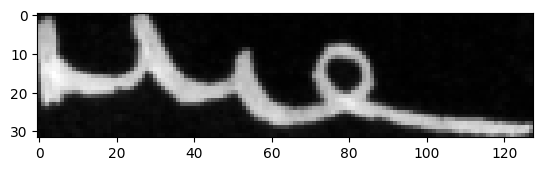



0riginal text =   West
Predicted text = Wet

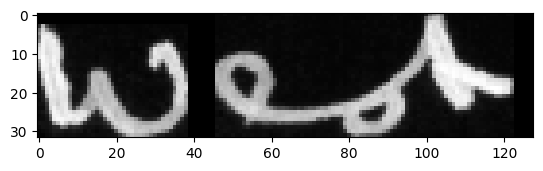



0riginal text =   German
Predicted text = German

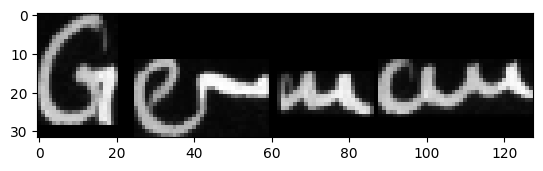



0riginal text =   .
Predicted text = .

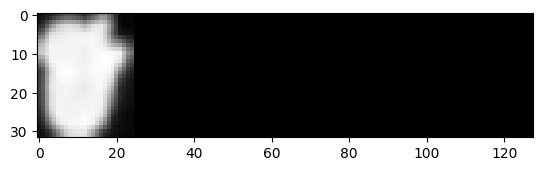



0riginal text =   PRESIDENT
Predicted text = PRESIDEnT

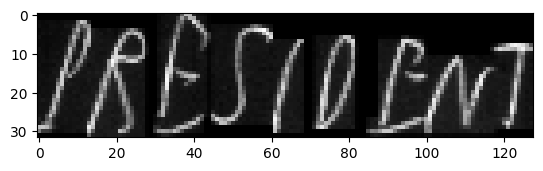



0riginal text =   KENNEDY
Predicted text = KENNEDY

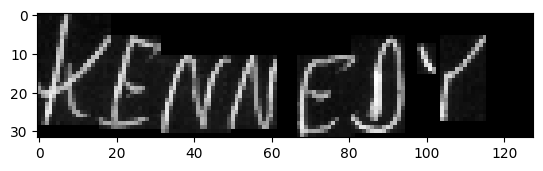



0riginal text =   is
Predicted text = in

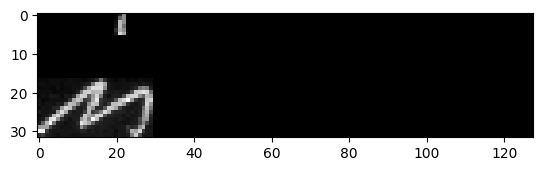



0riginal text =   ready
Predicted text = raly

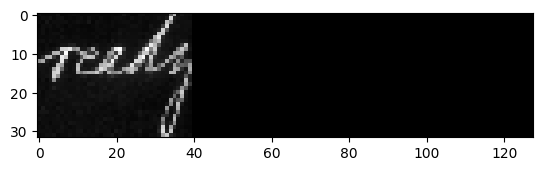



0riginal text =   to
Predicted text = to

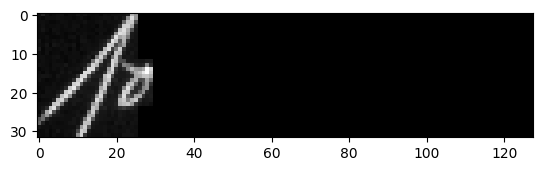



0riginal text =   get
Predicted text = get

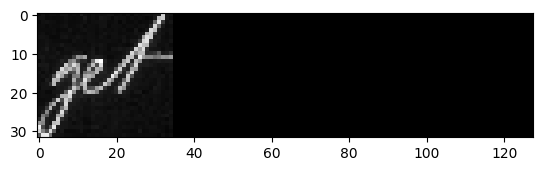



0riginal text =   tough
Predicted text = tough

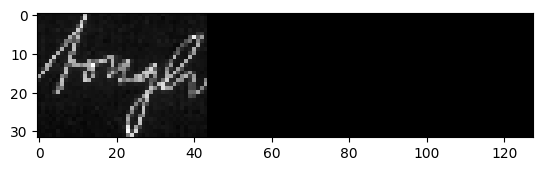



0riginal text =   over
Predicted text = sver

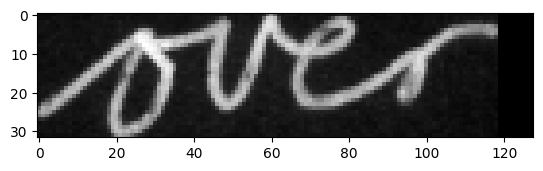



0riginal text =   Germany's
Predicted text = Gemay's

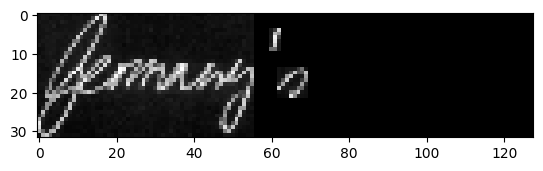



0riginal text =   cash
Predicted text = ash

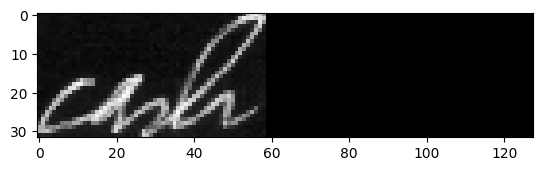



0riginal text =   offer
Predicted text = alter

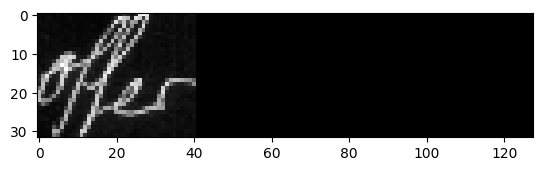



0riginal text =   to
Predicted text = to

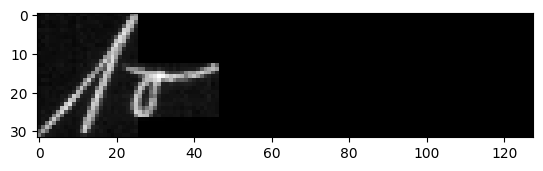



0riginal text =   help
Predicted text = baks

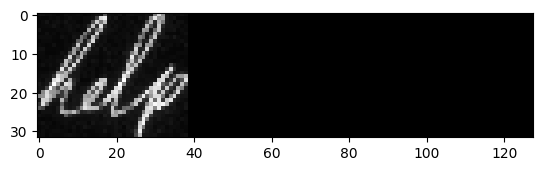



0riginal text =   America's
Predicted text = Urica's

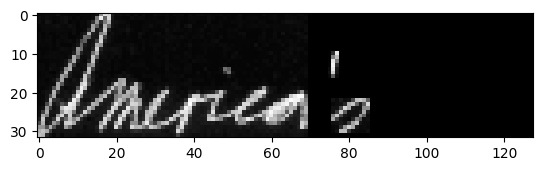



0riginal text =   balance
Predicted text = balre

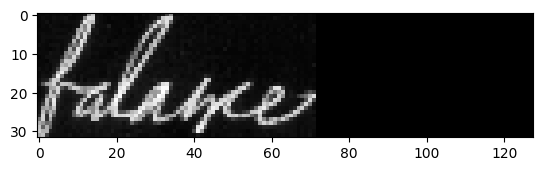



0riginal text =   of
Predicted text = of

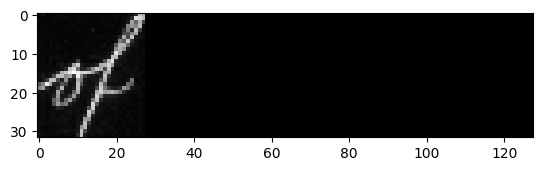



0riginal text =   payments
Predicted text = peyments

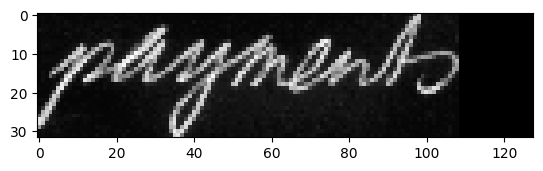



0riginal text =   He
Predicted text = Te

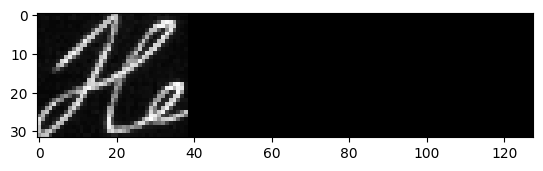



0riginal text =   said
Predicted text = sitl

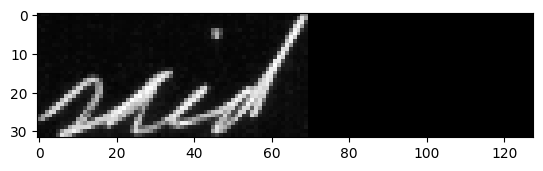



0riginal text =   bluntly
Predicted text = lanrly

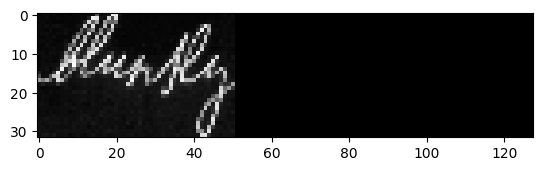



0riginal text =   in
Predicted text = in

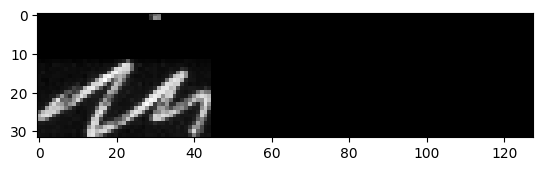



0riginal text =   Washington
Predicted text = Washigton

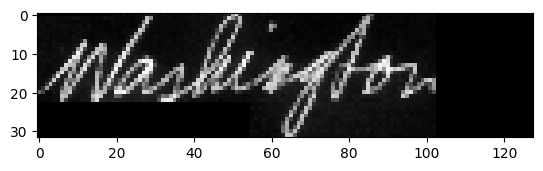



0riginal text =   yesterday
Predicted text = yestedy

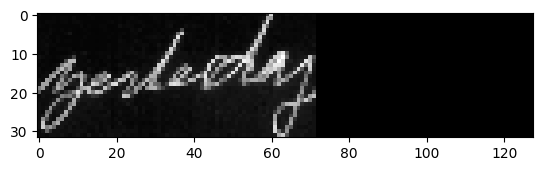



0riginal text =   that
Predicted text = tht

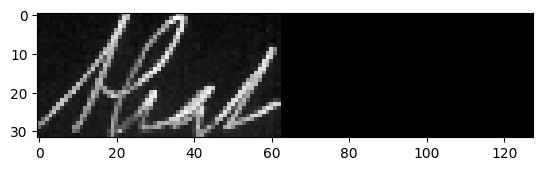



0riginal text =   the
Predicted text = the

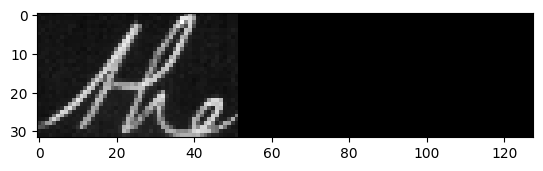



0riginal text =   offer
Predicted text = offer

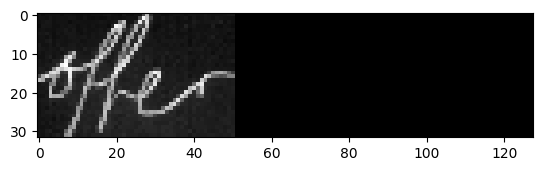



0riginal text =   357million
Predicted text = 357milln

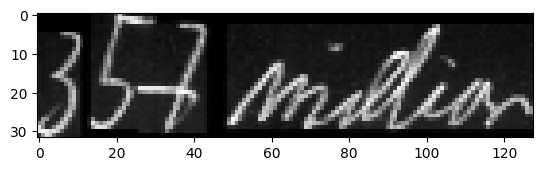



0riginal text =   -
Predicted text = -

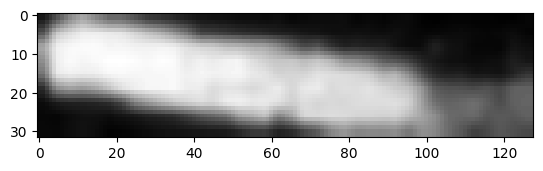



0riginal text =   was
Predicted text = ws

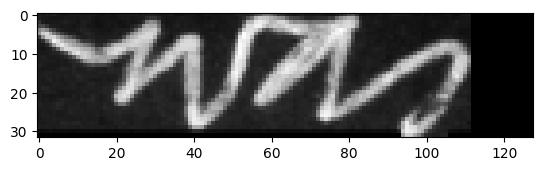



0riginal text =   not
Predicted text = nt

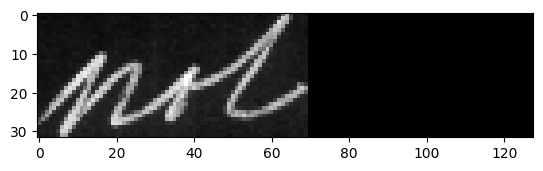



0riginal text =   good
Predicted text = gost

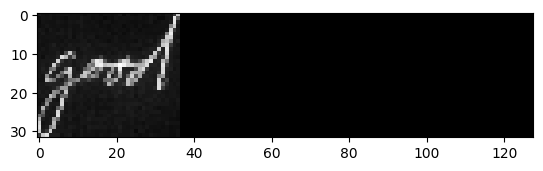



0riginal text =   enough
Predicted text = cuugh

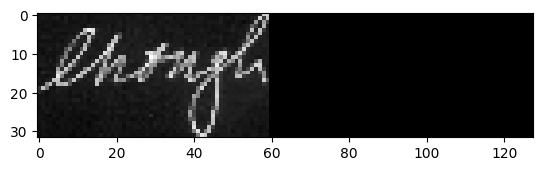



0riginal text =   .
Predicted text = .

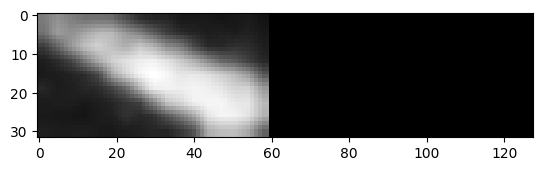



0riginal text =   And
Predicted text = n

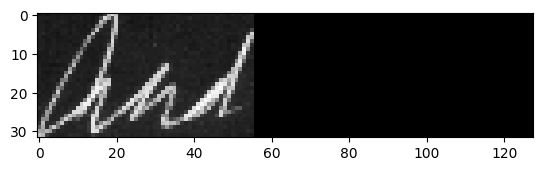



0riginal text =   he
Predicted text = he

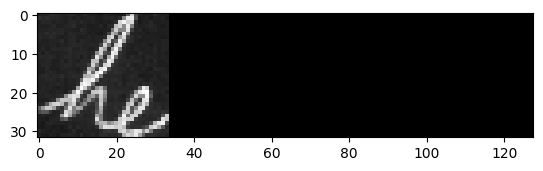



0riginal text =   that
Predicted text = tat

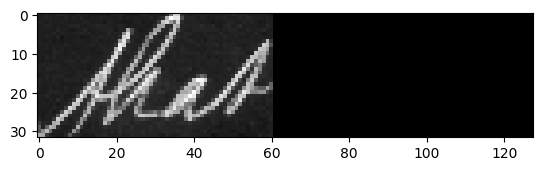



0riginal text =   his
Predicted text = to

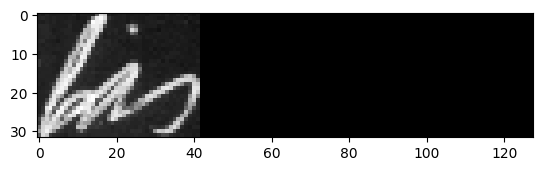



0riginal text =   Government
Predicted text = Government

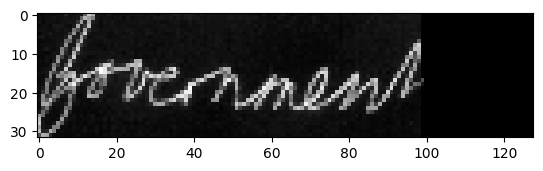



0riginal text =   would
Predicted text = would

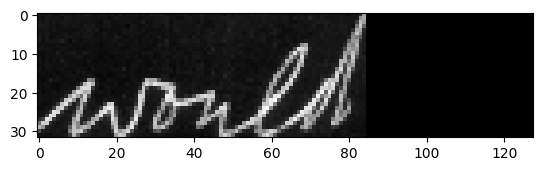



0riginal text =   try
Predicted text = by

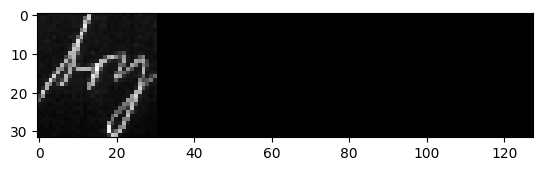



0riginal text =   to
Predicted text = to

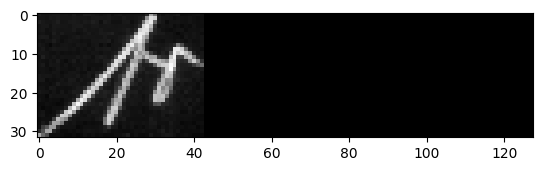



0riginal text =   get
Predicted text = gt

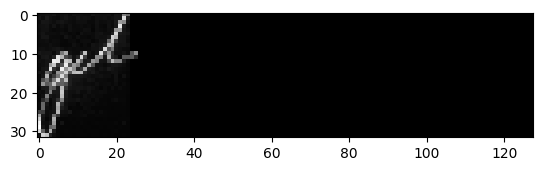



0riginal text =   Germany
Predicted text = Gemany

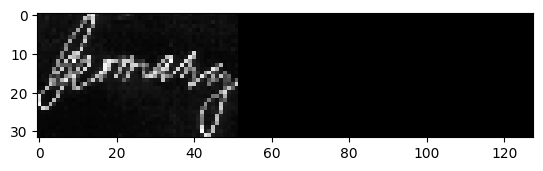



0riginal text =   to
Predicted text = to

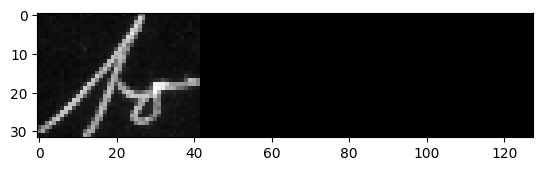



0riginal text =   more
Predicted text = mre

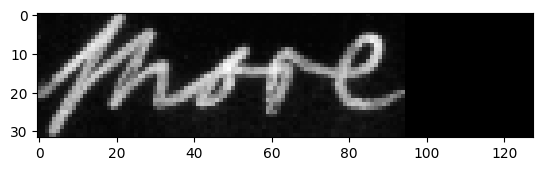



0riginal text =   .
Predicted text = .

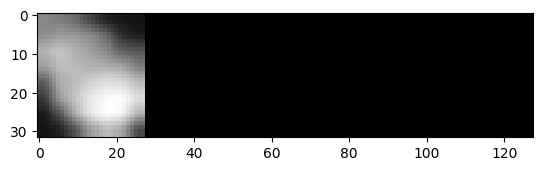



0riginal text =   He
Predicted text = He

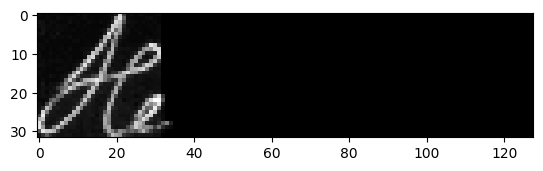



0riginal text =   did
Predicted text = sit

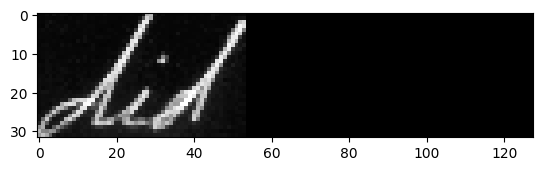



0riginal text =   not
Predicted text = nt

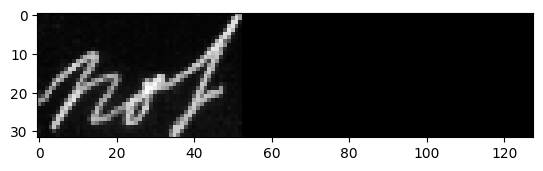



0riginal text =   mention
Predicted text = mertion

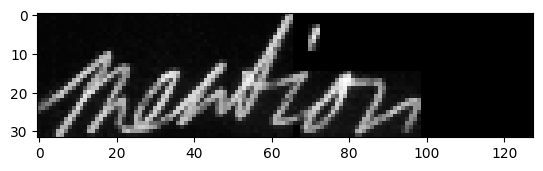



0riginal text =   personal
Predicted text = rerint

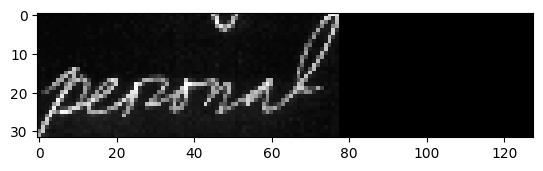



0riginal text =   talks
Predicted text = talks

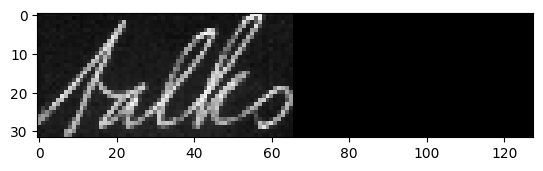



0riginal text =   with
Predicted text = with

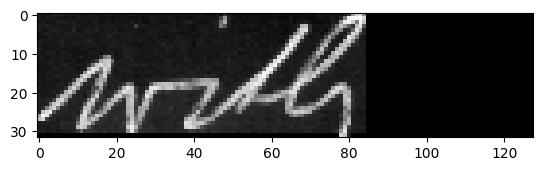



0riginal text =   Adenauer
Predicted text = Aenauer

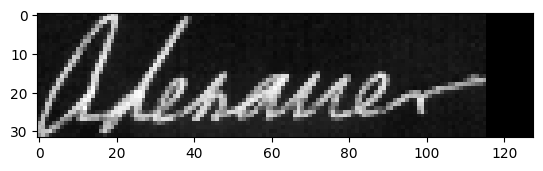



0riginal text =   ,
Predicted text = ,

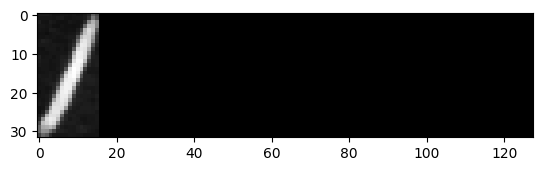



0riginal text =   the
Predicted text = tho

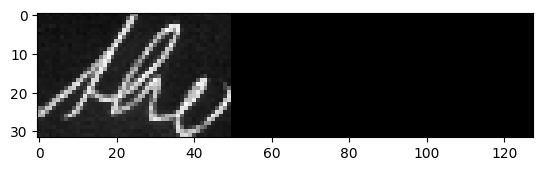



0riginal text =   West
Predicted text = Wert

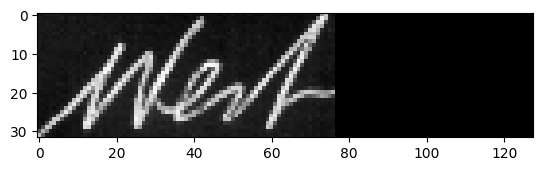



0riginal text =   German
Predicted text = Gmmn

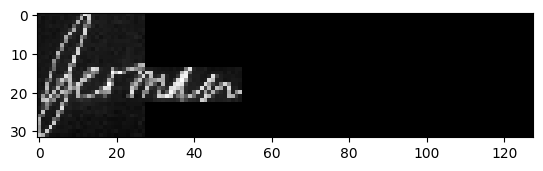



0riginal text =   Chancellor
Predicted text = Clenalor

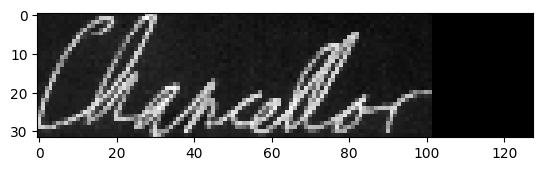



0riginal text =   .
Predicted text = .

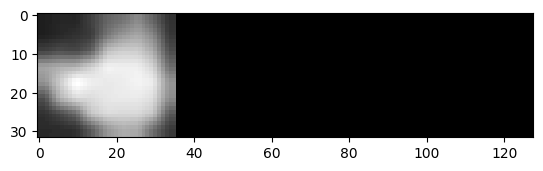



0riginal text =   But
Predicted text = Bat

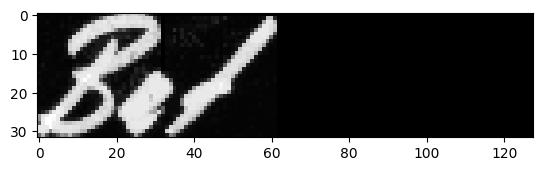



0riginal text =   he
Predicted text = be

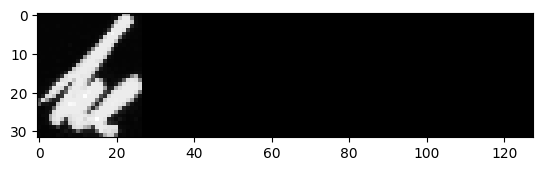



0riginal text =   discussions
Predicted text = dicsssions

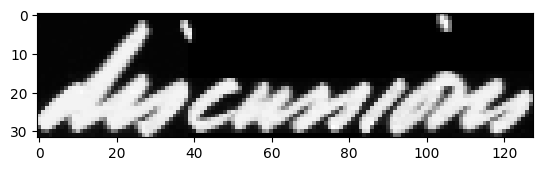



0riginal text =   "
Predicted text = .

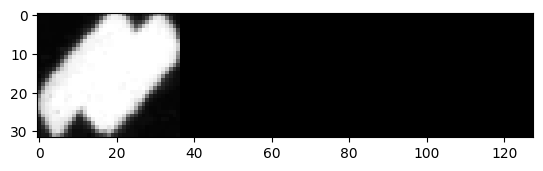



0riginal text =   on
Predicted text = ar

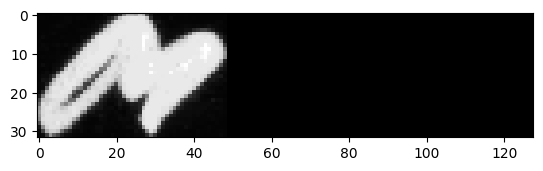



0riginal text =   a
Predicted text = a

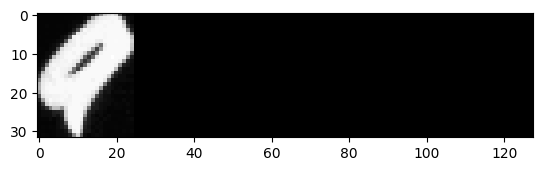



0riginal text =   higher
Predicted text = digfer

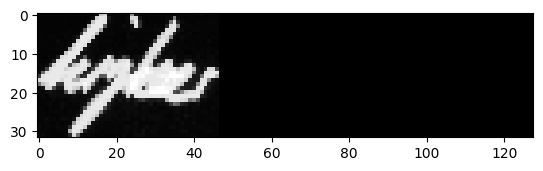



0riginal text =   useful
Predicted text = uoth

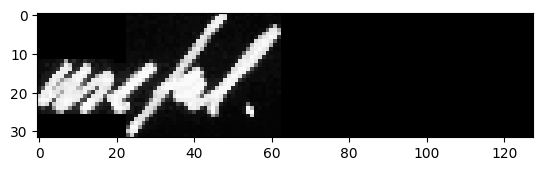



0riginal text =   .
Predicted text = .

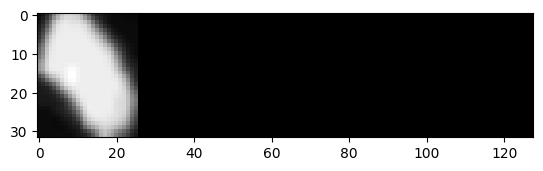



0riginal text =   The
Predicted text = Te

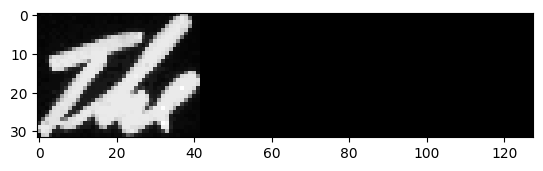



0riginal text =   President
Predicted text = Preident

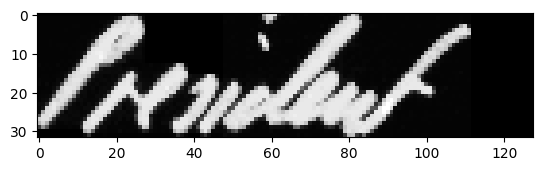



0riginal text =   will
Predicted text = will

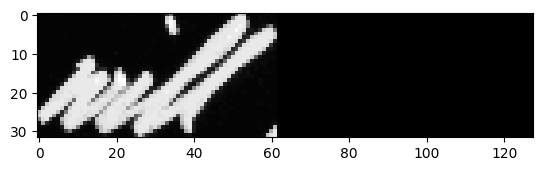



0riginal text =   probably
Predicted text = yrobely

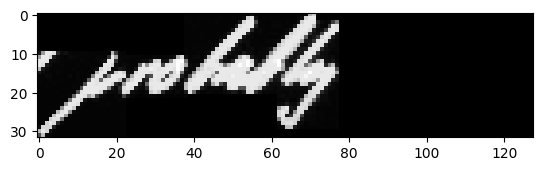



0riginal text =   the
Predicted text = he

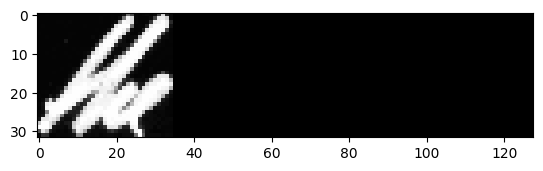



0riginal text =   problem
Predicted text = proble

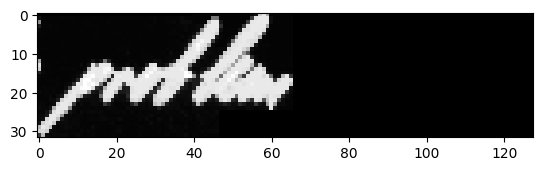



0riginal text =   with
Predicted text = wiltl

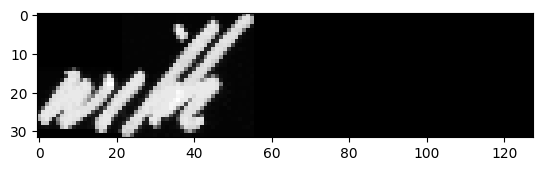



0riginal text =   Dr.
Predicted text = Dr.

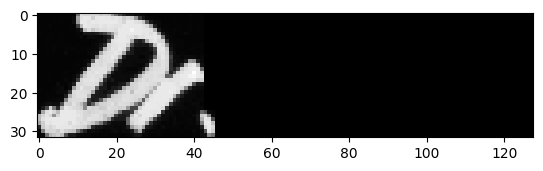



0riginal text =   Brentano
Predicted text = Prentana

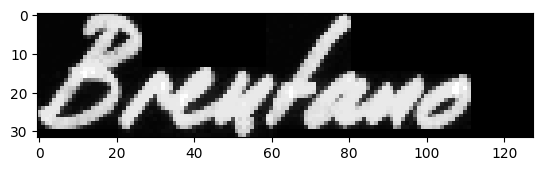



0riginal text =   ,
Predicted text = ,

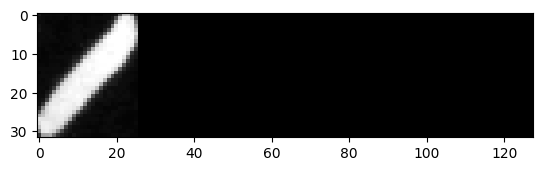



0riginal text =   the
Predicted text = the

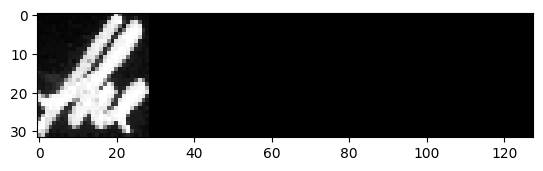



0riginal text =   West
Predicted text = Ao

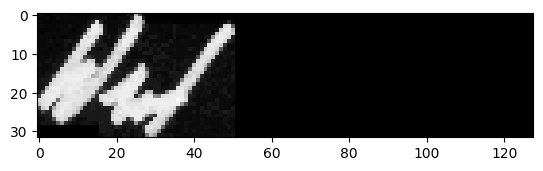



0riginal text =   German
Predicted text = Groo

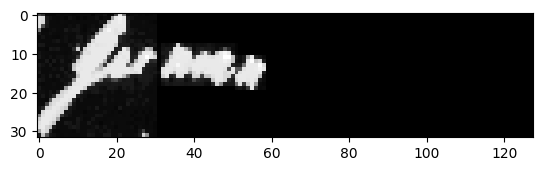



0riginal text =   Minister
Predicted text = Miister

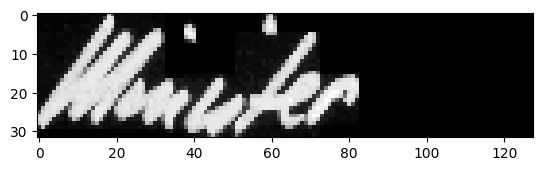



0riginal text =   ,
Predicted text = ,

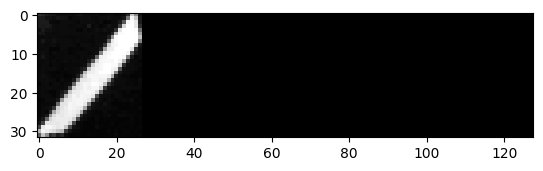



0riginal text =   who
Predicted text = aho

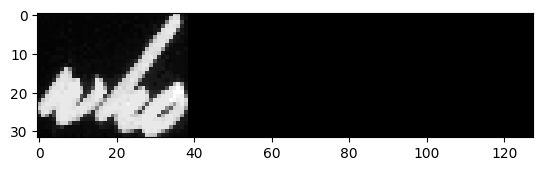



0riginal text =   is
Predicted text = is

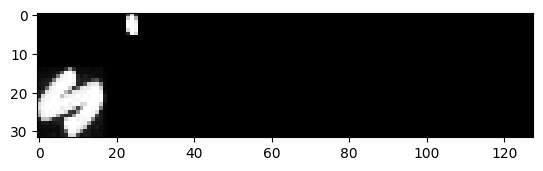



0riginal text =   due
Predicted text = de

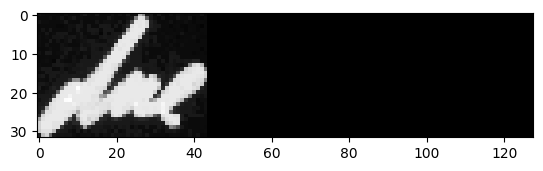



0riginal text =   in
Predicted text = 

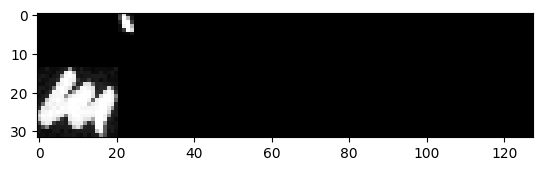



0riginal text =   Washington
Predicted text = thahligtn

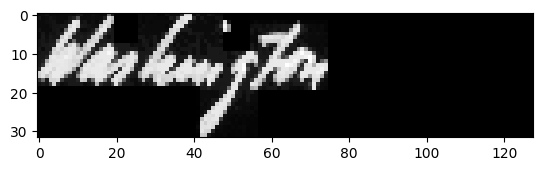



0riginal text =   next
Predicted text = nxt

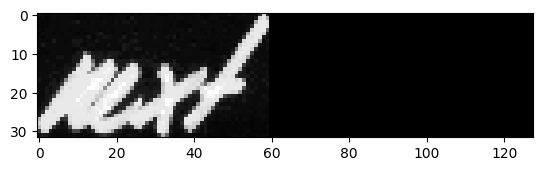



0riginal text =   week
Predicted text = red

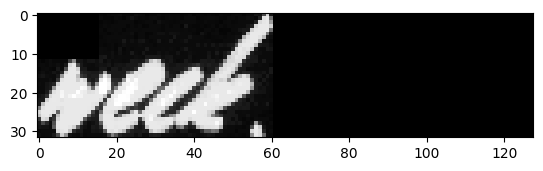



0riginal text =   A
Predicted text = ,

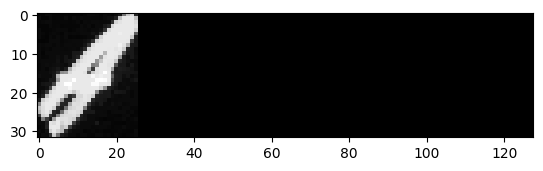



0riginal text =   big
Predicted text = bi

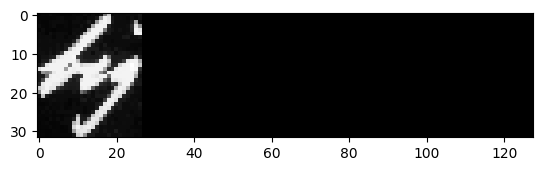



0riginal text =   payment
Predicted text = pamet

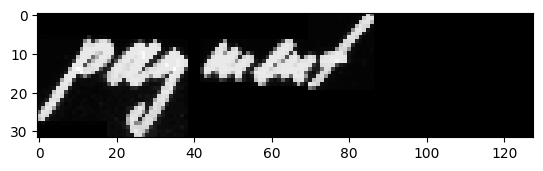



0riginal text =   of
Predicted text = of

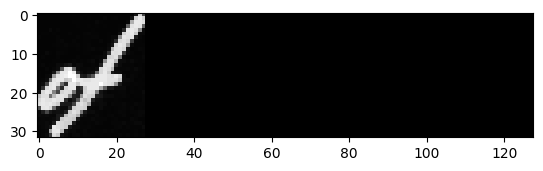



0riginal text =   a
Predicted text = ,

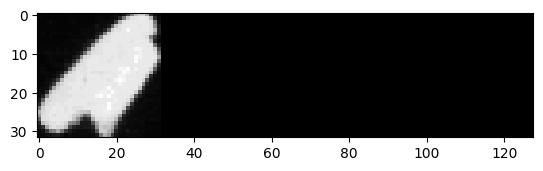



0riginal text =   210million
Predicted text = 210millson

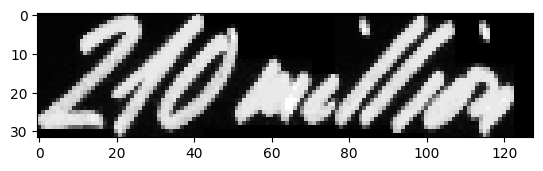



0riginal text =   debt
Predicted text = de

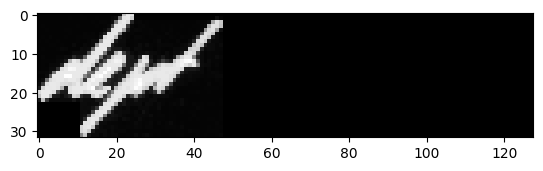



0riginal text =   to
Predicted text = to

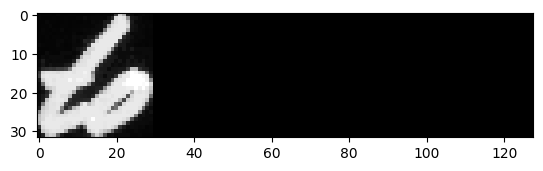



0riginal text =   America
Predicted text = Imeict

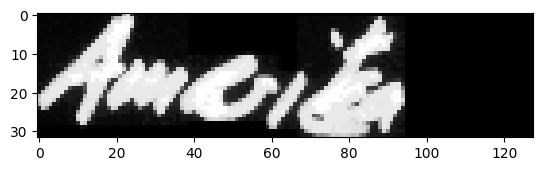



0riginal text =   United
Predicted text = Ucited

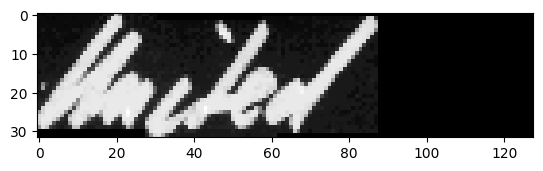



0riginal text =   States
Predicted text = Btates

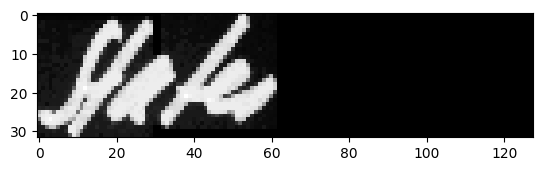



0riginal text =   officials
Predicted text = cficist

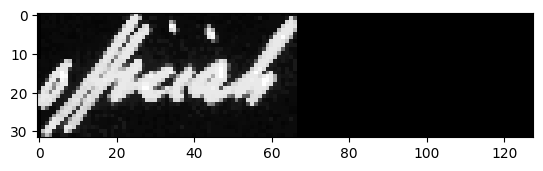



0riginal text =   quickly
Predicted text = qaitl

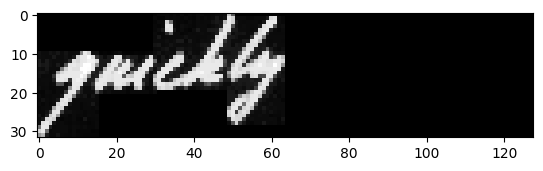



0riginal text =   point
Predicted text = pint

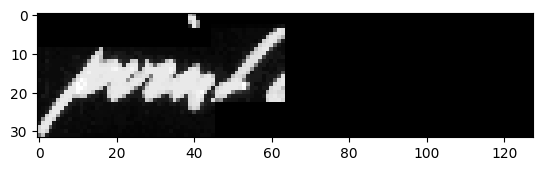



0riginal text =   out
Predicted text = aut

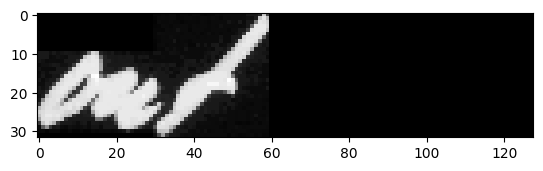



0riginal text =   that
Predicted text = tat

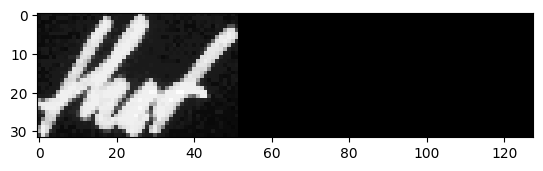



0riginal text =   this
Predicted text = th.

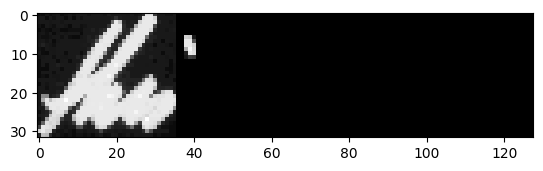



0riginal text =   is
Predicted text = i

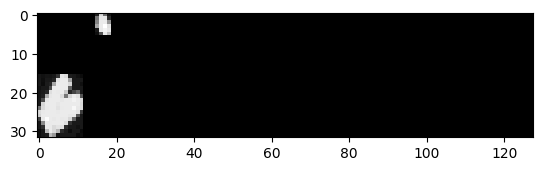



0riginal text =   due
Predicted text = he

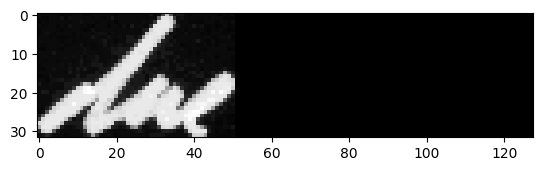



0riginal text =   to
Predicted text = to

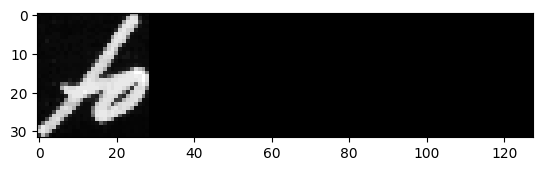



0riginal text =   America
Predicted text = America

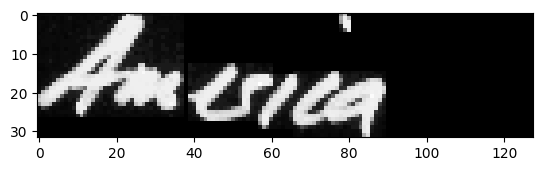



0riginal text =   anyway
Predicted text = aywy

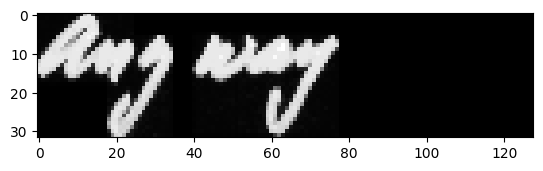



0riginal text =   .
Predicted text = .

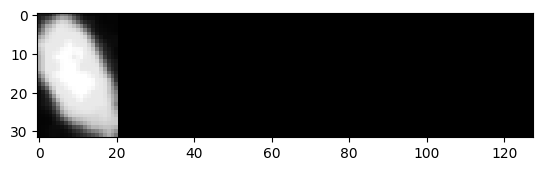



0riginal text =   level
Predicted text = level

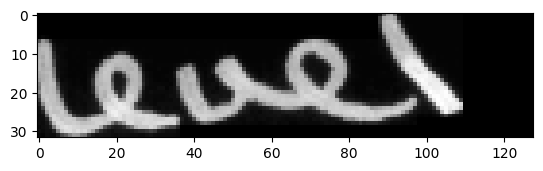



0riginal text =   than
Predicted text = tha

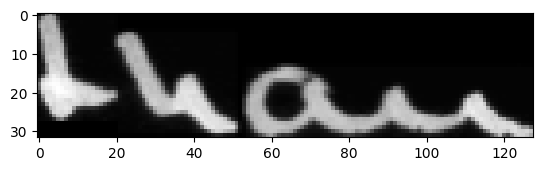



0riginal text =   in
Predicted text = in

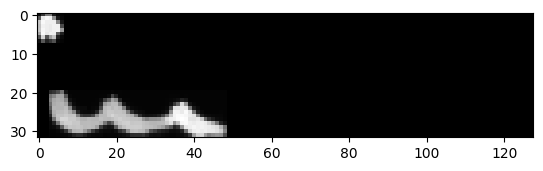



0riginal text =   the
Predicted text = the

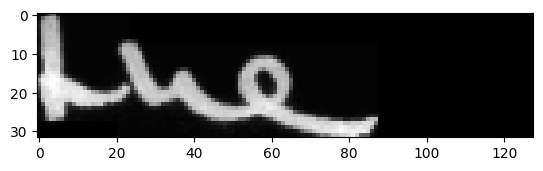



0riginal text =   past
Predicted text = poot

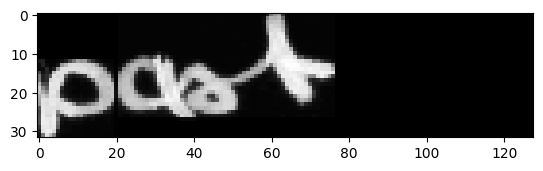



0riginal text =   "
Predicted text = "

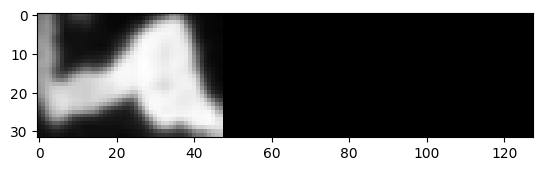



0riginal text =   be
Predicted text = be

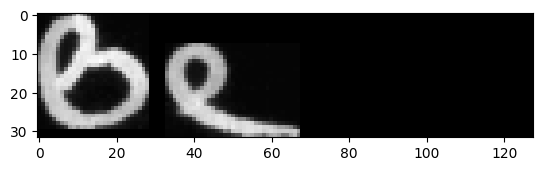



0riginal text =   useful
Predicted text = wetu

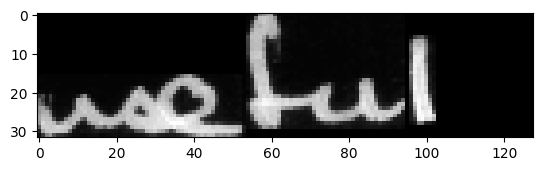



0riginal text =   .
Predicted text = .

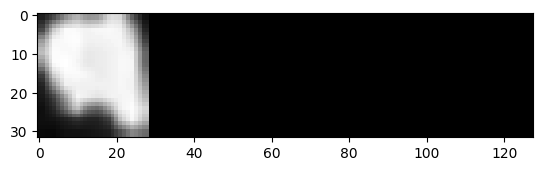



0riginal text =   The
Predicted text = The

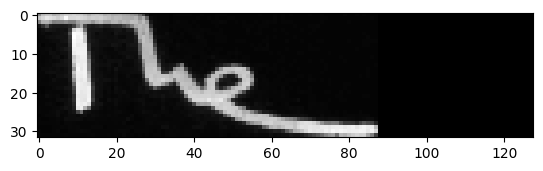



0riginal text =   President
Predicted text = Pvesiment

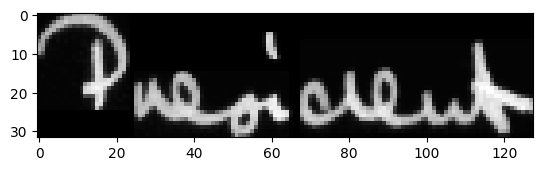



0riginal text =   will
Predicted text = will

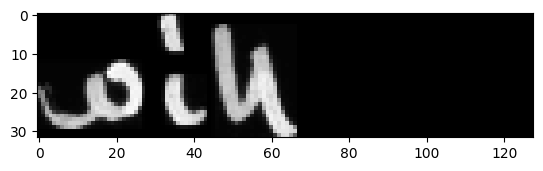



0riginal text =   probably
Predicted text = probably

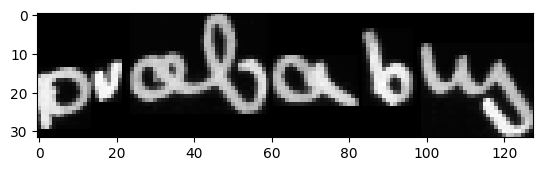



0riginal text =   discuss
Predicted text = discus

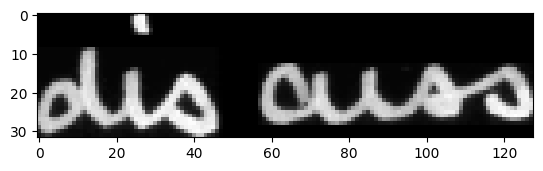



0riginal text =   the
Predicted text = the

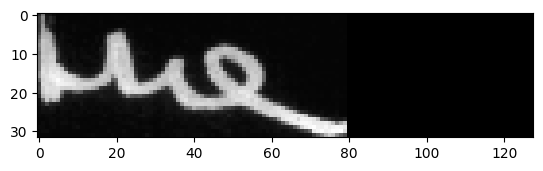



0riginal text =   with
Predicted text = with

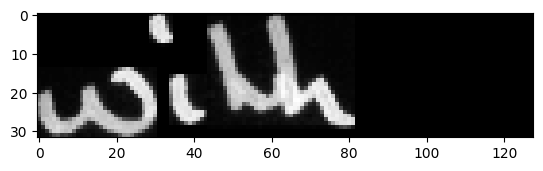



0riginal text =   Dr.
Predicted text = D.

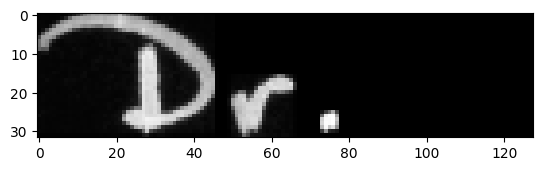



0riginal text =   Brentano
Predicted text = Brentons

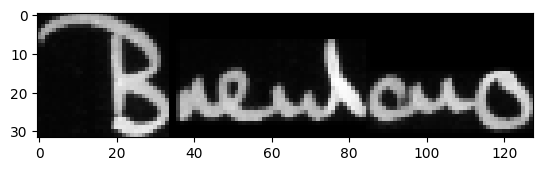



0riginal text =   ,
Predicted text = ,

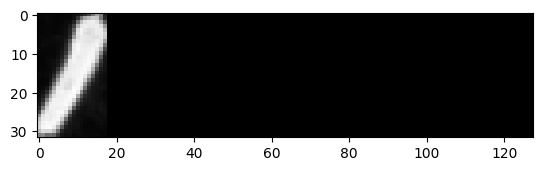



0riginal text =   the
Predicted text = the

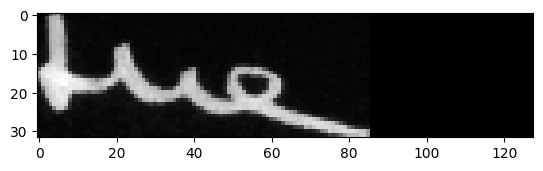



0riginal text =   West
Predicted text = West

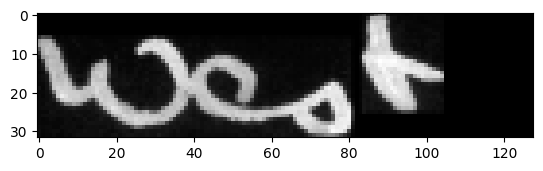



0riginal text =   German
Predicted text = German

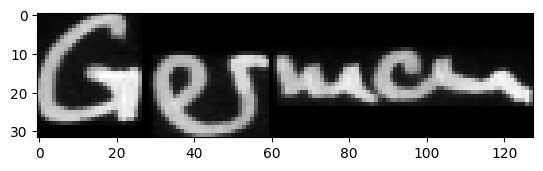



0riginal text =   Foreign
Predicted text = Fecign

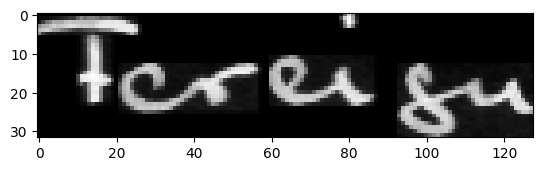



0riginal text =   Minister
Predicted text = Ministes

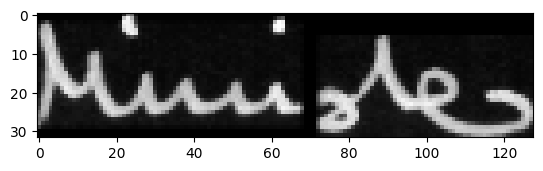



0riginal text =   who
Predicted text = who

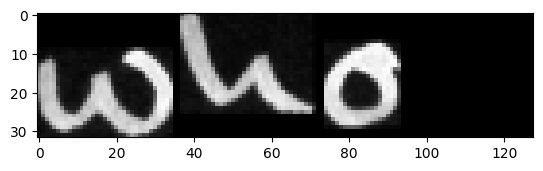



0riginal text =   is
Predicted text = is

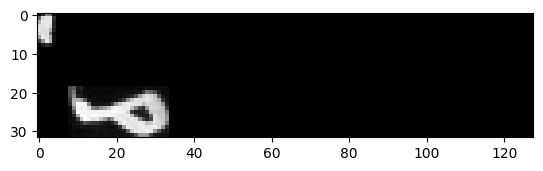



0riginal text =   due
Predicted text = dte

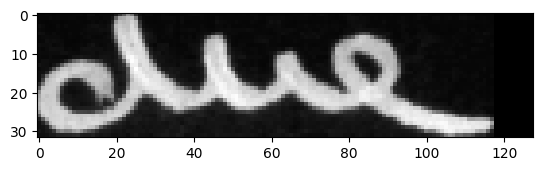



0riginal text =   in
Predicted text = in

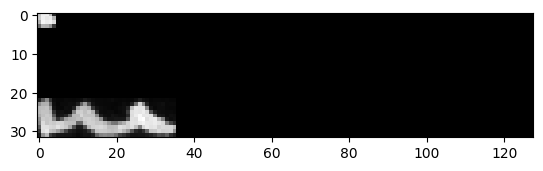



0riginal text =   Washington
Predicted text = Waslington

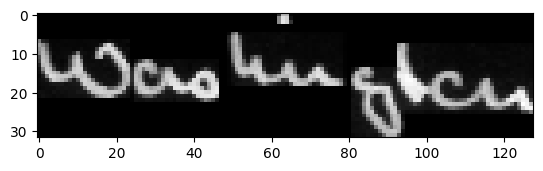



0riginal text =   next
Predicted text = next

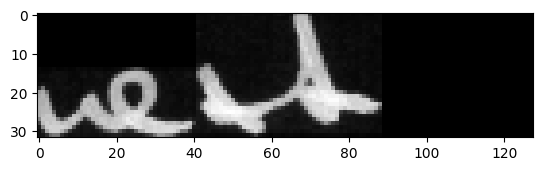



0riginal text =   week
Predicted text = meeek

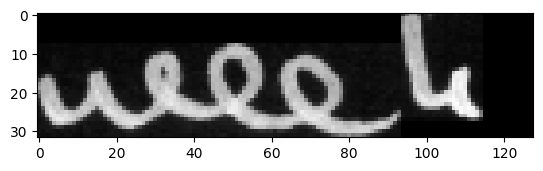



0riginal text =   .
Predicted text = -

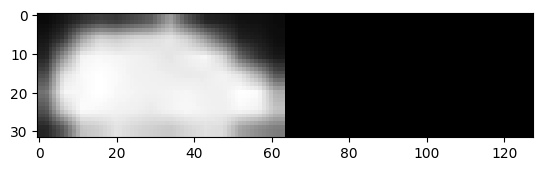



0riginal text =   A
Predicted text = A

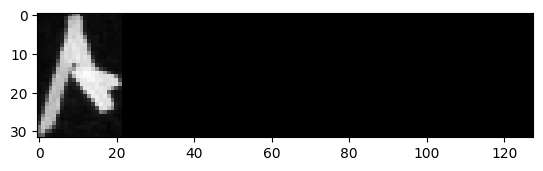



0riginal text =   slice
Predicted text = slice

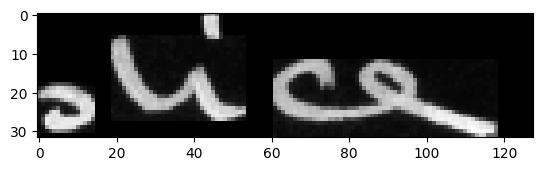



0riginal text =   of
Predicted text = of

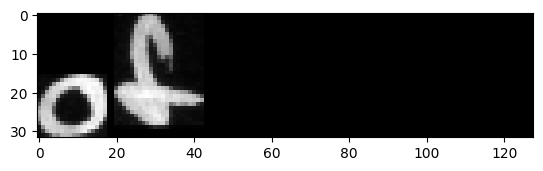



0riginal text =   Germany's
Predicted text = Germany's

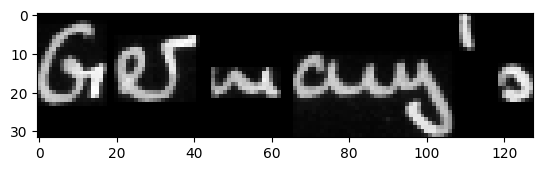



0riginal text =   "
Predicted text = "

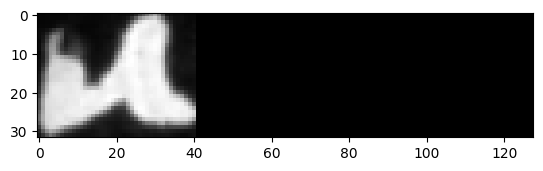



0riginal text =   aid
Predicted text = aid

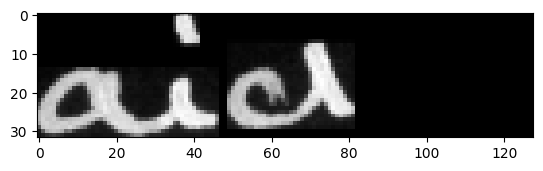



0riginal text =   "
Predicted text = "

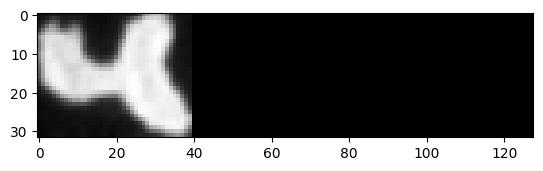



0riginal text =   is
Predicted text = is

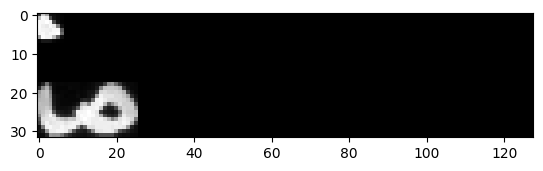



0riginal text =   the
Predicted text = the

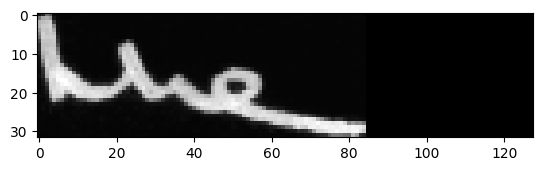



0riginal text =   early
Predicted text = earty

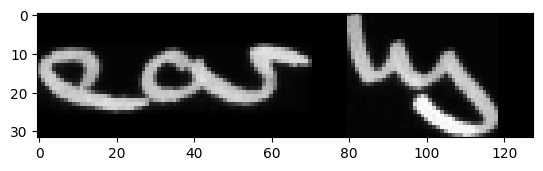



0riginal text =   of
Predicted text = of

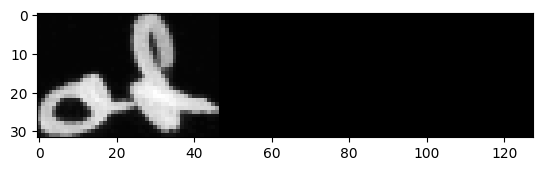



0riginal text =   a
Predicted text = a

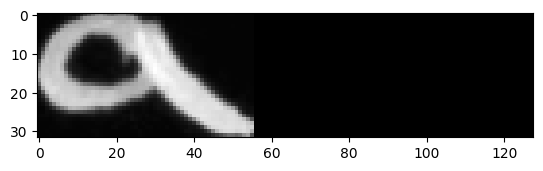



0riginal text =   210million
Predicted text = 210million

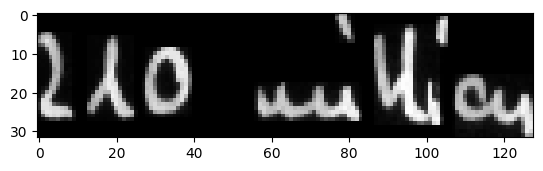



0riginal text =   debt
Predicted text = dept

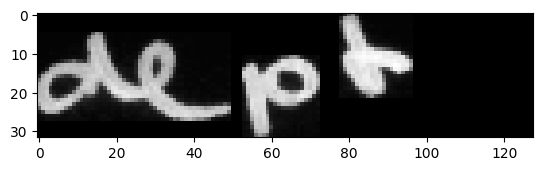



0riginal text =   to
Predicted text = to

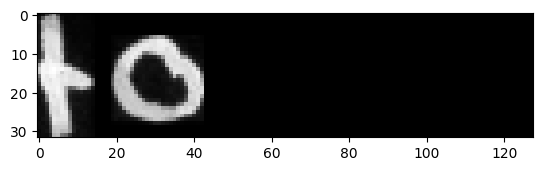



0riginal text =   America
Predicted text = America

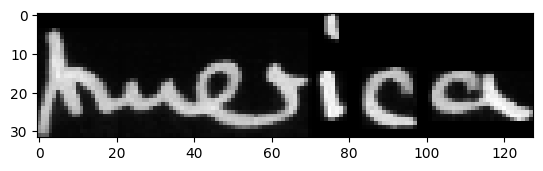



0riginal text =   .
Predicted text = .

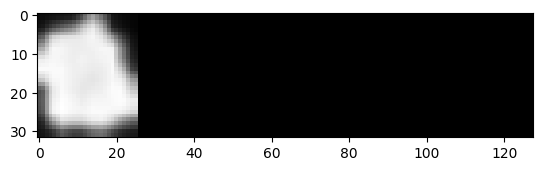



0riginal text =   United
Predicted text = United

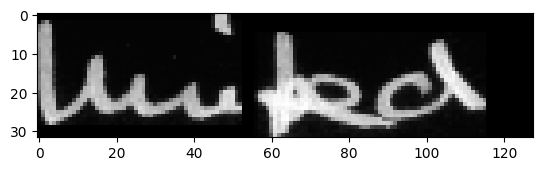



0riginal text =   States
Predicted text = States

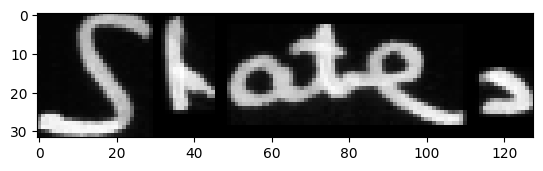



0riginal text =   quickly
Predicted text = quickly

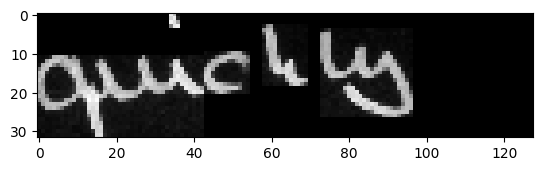



0riginal text =   point
Predicted text = paint

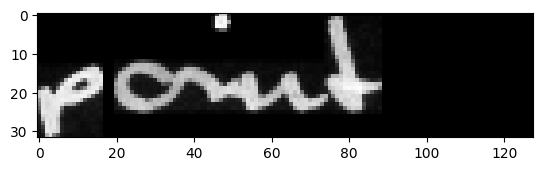



0riginal text =   out
Predicted text = out

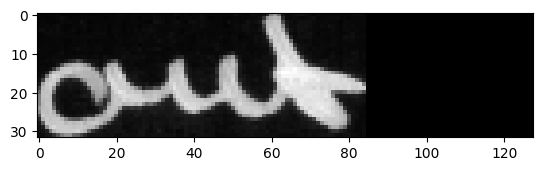



0riginal text =   that
Predicted text = that

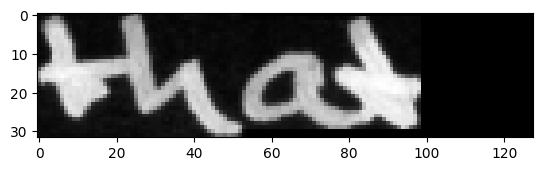



0riginal text =   this
Predicted text = ths

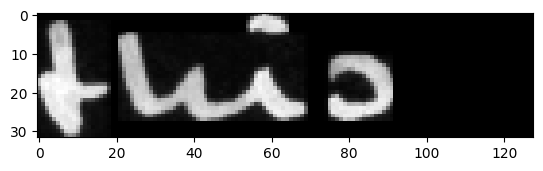



0riginal text =   is
Predicted text = is

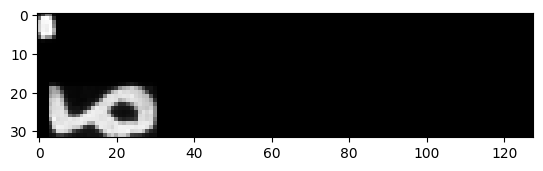



0riginal text =   money
Predicted text = money

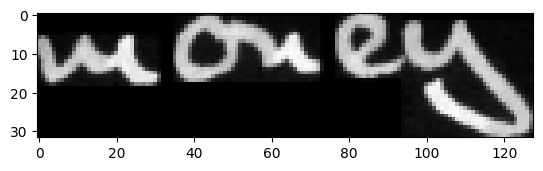



0riginal text =   due
Predicted text = dre

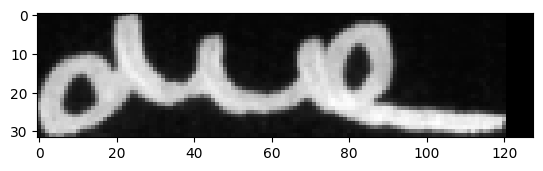



0riginal text =   to
Predicted text = to

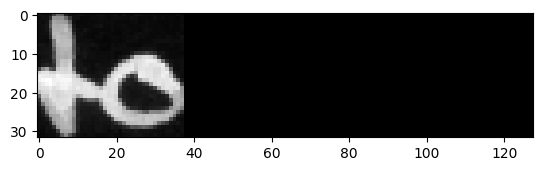



0riginal text =   anyway
Predicted text = answay

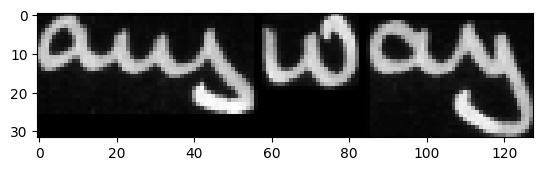



0riginal text =   .
Predicted text = .

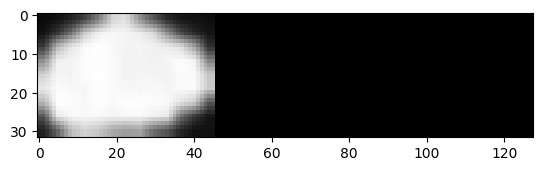



0riginal text =   But
Predicted text = But

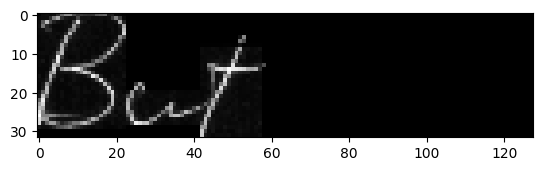



0riginal text =   he
Predicted text = he

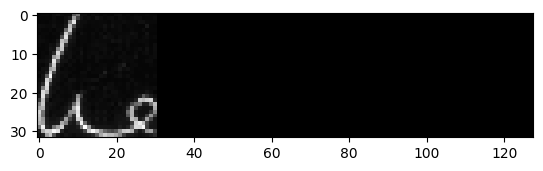



0riginal text =   said
Predicted text = sacid

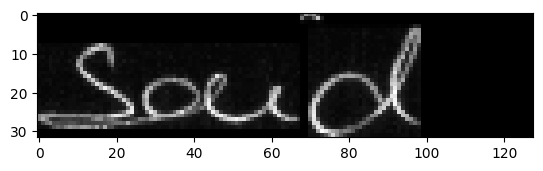



0riginal text =   discussions
Predicted text = disccssions

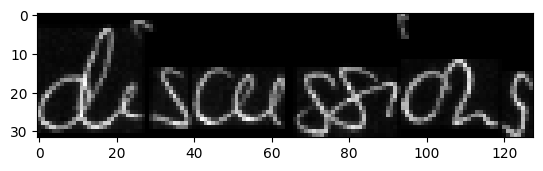



0riginal text =   "
Predicted text = "

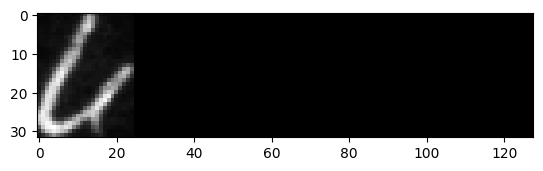



0riginal text =   on
Predicted text = on

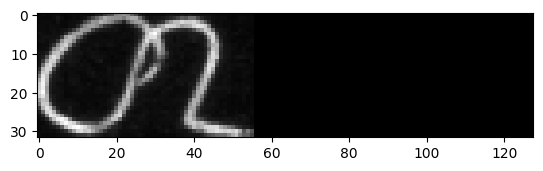



0riginal text =   a
Predicted text = a

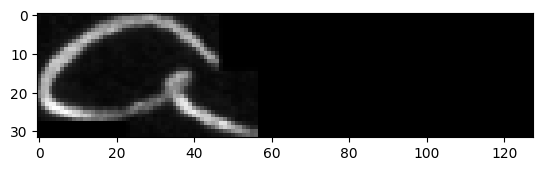



0riginal text =   level
Predicted text = levcl

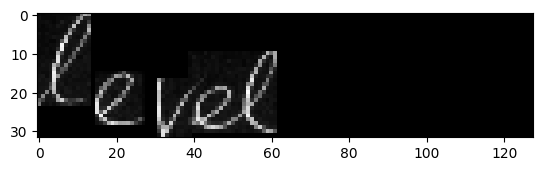



0riginal text =   than
Predicted text = thac

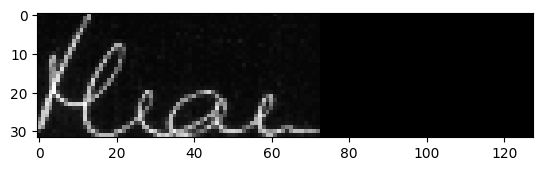



0riginal text =   in
Predicted text = I

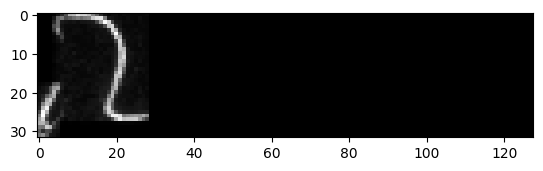



0riginal text =   the
Predicted text = thee

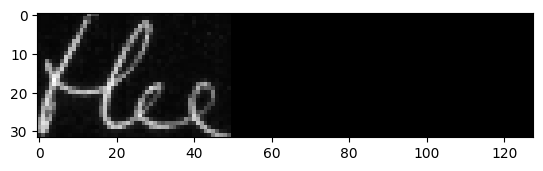



0riginal text =   past
Predicted text = pooste

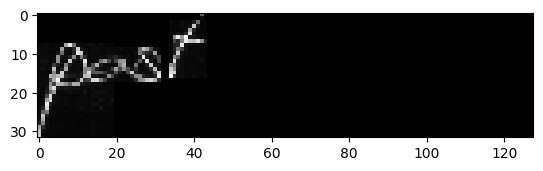



0riginal text =   "
Predicted text = "

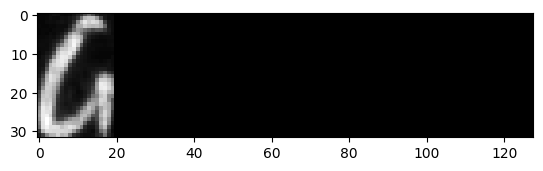

In [ ]:
# predict outputs on validation images
prediction = act_model.predict(train_images[2000:2200])

# use CTC decoder
decoded = K.ctc_decode(prediction,
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]

out = K.get_value(decoded)

# see the results
for i, x in enumerate(out):
    print("0riginal text =  ", train_original_text[2000+i])
    print("Predicted text = ", end = '')
    for p in x:
        if int(p) != -1:
            print(char_list[int(p)], end = '')
    plt.imshow(train_images[2000+i].reshape(32,128), cmap=plt.cm.gray)
    plt.show()
    print('\n')

### Prediction 2

7/7 [==============================] - 0s 19ms/step
0riginal text =   with
Predicted text = with

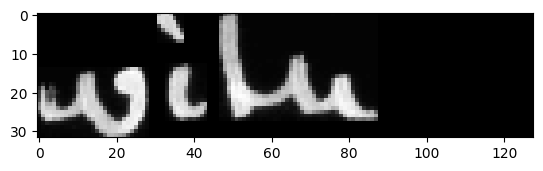



0riginal text =   the
Predicted text = the

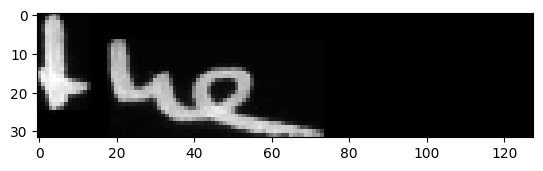



0riginal text =   answer
Predicted text = answer

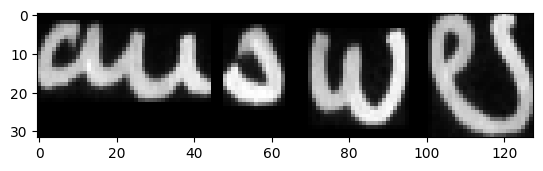



0riginal text =   on
Predicted text = on

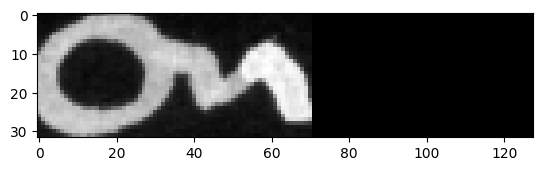



0riginal text =   February
Predicted text = Fetmary

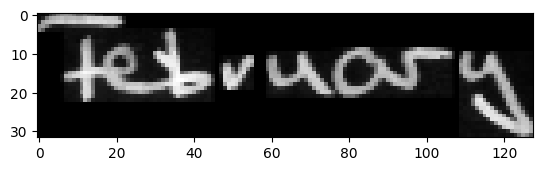



0riginal text =   .
Predicted text = .

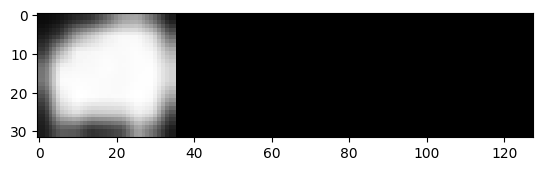



0riginal text =   This
Predicted text = This

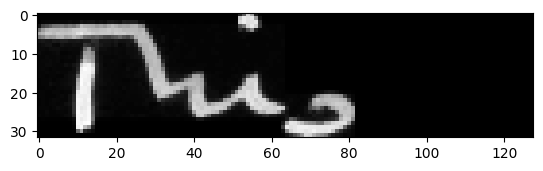



0riginal text =   surprising
Predicted text = surprice

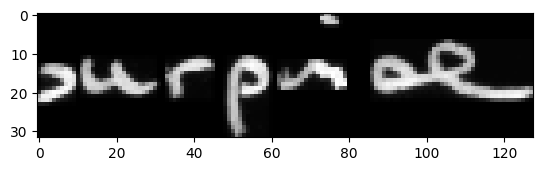



0riginal text =   statement
Predicted text = otatement

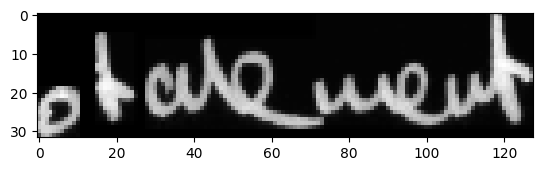



0riginal text =   was
Predicted text = was

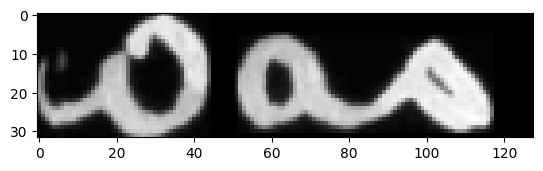



0riginal text =   a
Predicted text = a

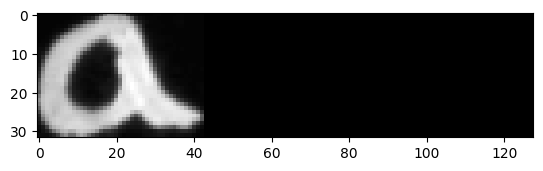



0riginal text =   sharp
Predicted text = sharp

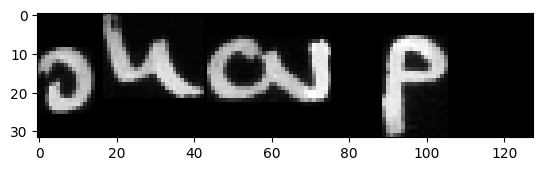



0riginal text =   about-
Predicted text = about-

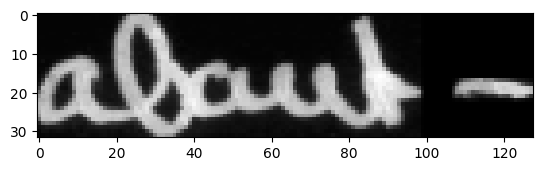



0riginal text =   face
Predicted text = face

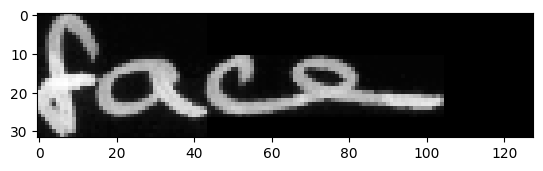



0riginal text =   his
Predicted text = his

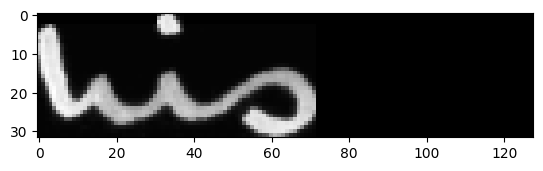



0riginal text =   warnings
Predicted text = wernings

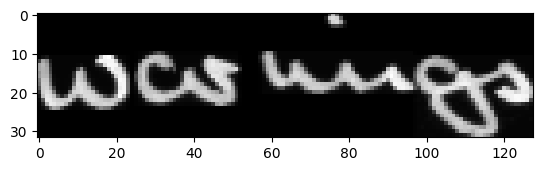



0riginal text =   during
Predicted text = duing

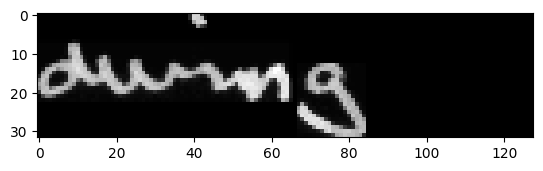



0riginal text =   the
Predicted text = the

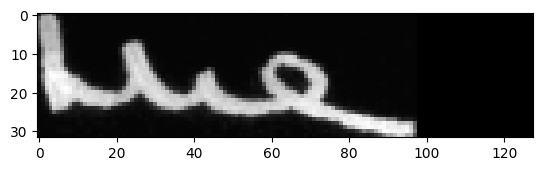



0riginal text =   Presidential
Predicted text = Presidential

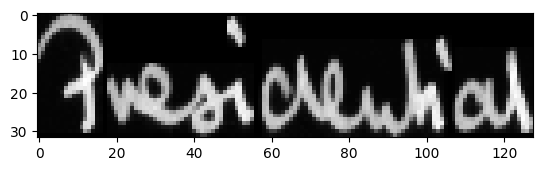



0riginal text =   election
Predicted text = election

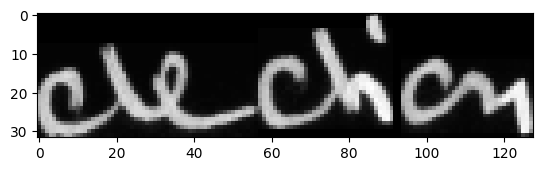



0riginal text =   campaign
Predicted text = campcipon

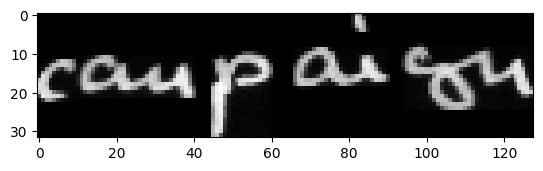



0riginal text =   .
Predicted text = .

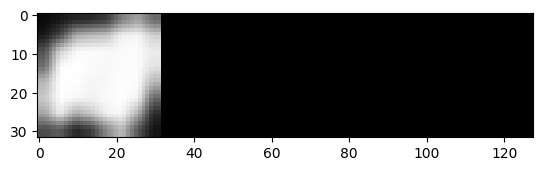



0riginal text =   He
Predicted text = He

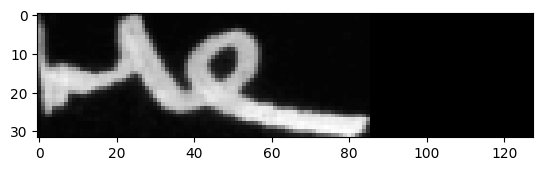



0riginal text =   slackness
Predicted text = slackness

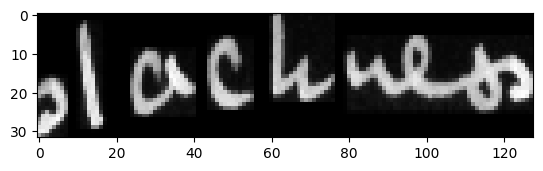



0riginal text =   in
Predicted text = in

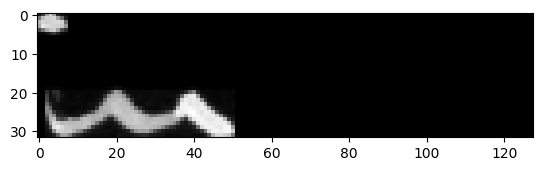



0riginal text =   the
Predicted text = the

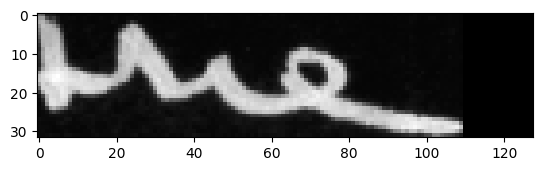



0riginal text =   Eisenhower
Predicted text = Ssenhouer

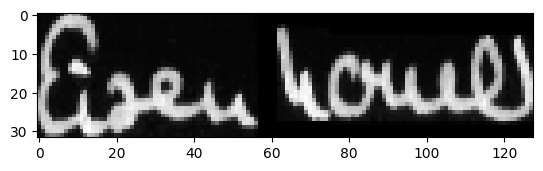



0riginal text =   Administration
Predicted text = Admiistation

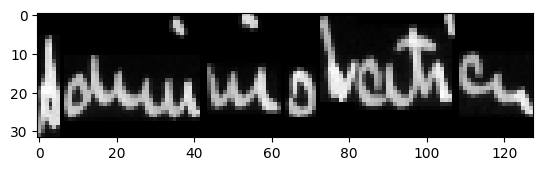



0riginal text =   had
Predicted text = had

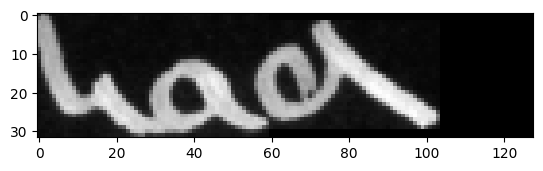



0riginal text =   caused
Predicted text = caused

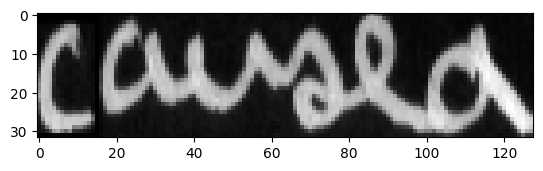



0riginal text =   America
Predicted text = America

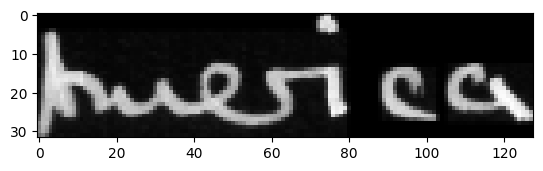



0riginal text =   to
Predicted text = to

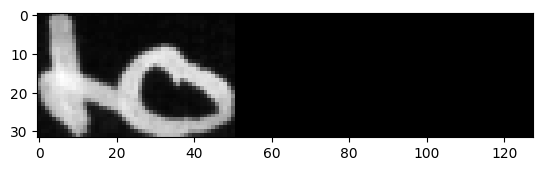



0riginal text =   behind
Predicted text = behind

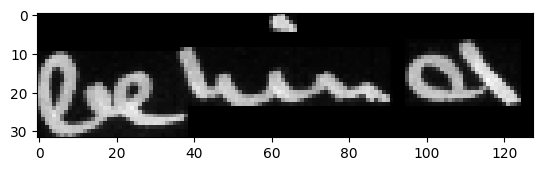



0riginal text =   Russia
Predicted text = Ressia

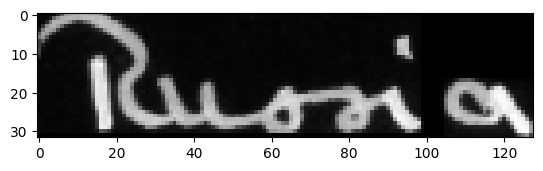



0riginal text =   in
Predicted text = in

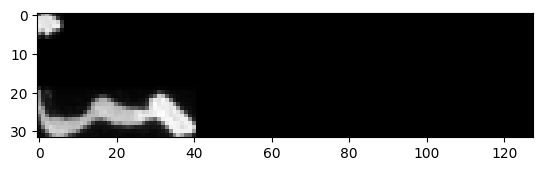



0riginal text =   nuclear
Predicted text = mclear

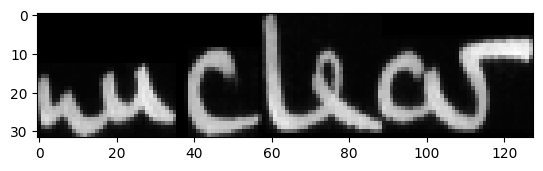



0riginal text =   development
Predicted text = devetopment

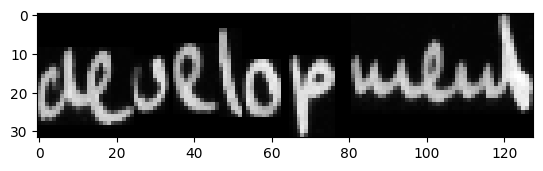



0riginal text =   .
Predicted text = .

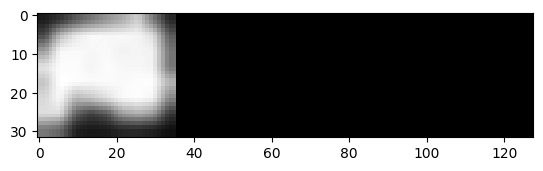



0riginal text =   President
Predicted text = President

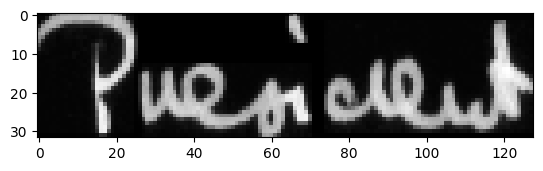



0riginal text =   Kennedy
Predicted text = Kemedy

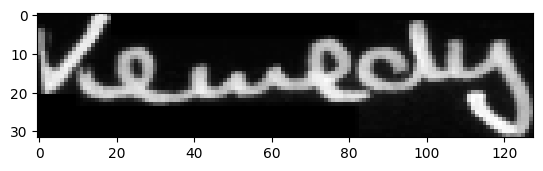



0riginal text =   did
Predicted text = did

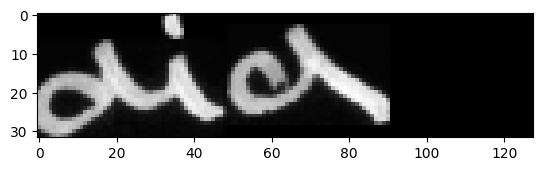



0riginal text =   best
Predicted text = best

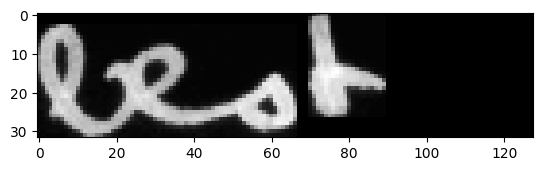



0riginal text =   to
Predicted text = to

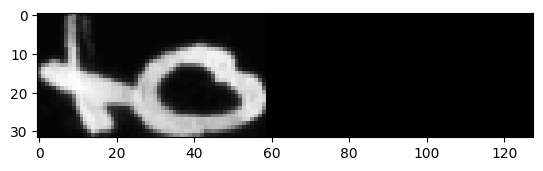



0riginal text =   avoid
Predicted text = avoid

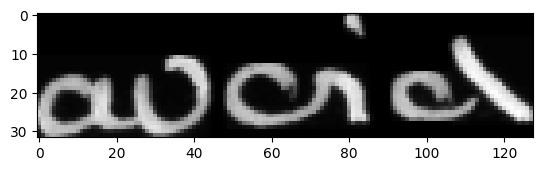



0riginal text =   giving
Predicted text = giving

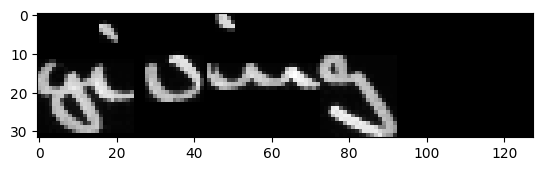



0riginal text =   Pressmen
Predicted text = Presmen

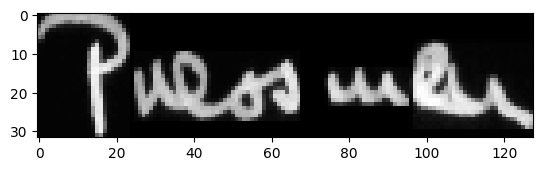



0riginal text =   a
Predicted text = a

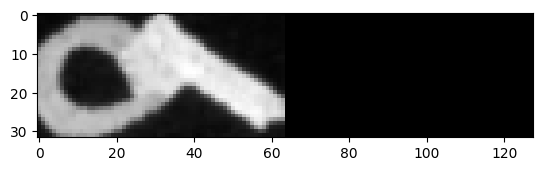



0riginal text =   direct
Predicted text = direct

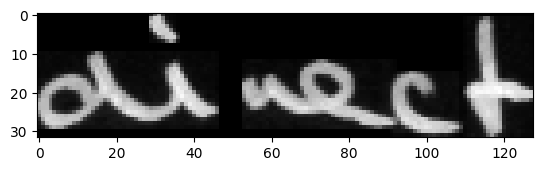



0riginal text =   answer
Predicted text = awwer

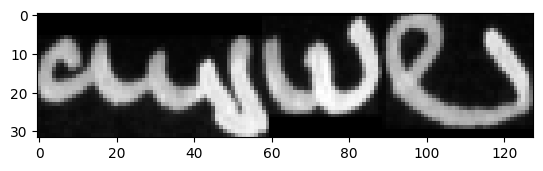



0riginal text =   .
Predicted text = .

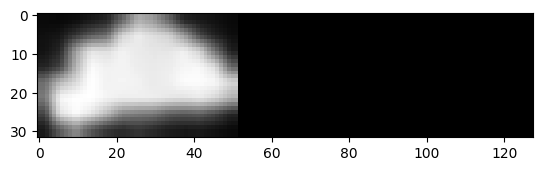



0riginal text =   Brown
Predicted text = Brown

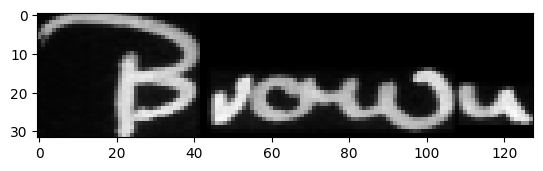



0riginal text =   CHILDREN
Predicted text = CHILDTEN

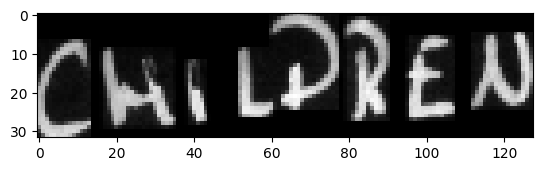



0riginal text =   TWO
Predicted text = ThwO

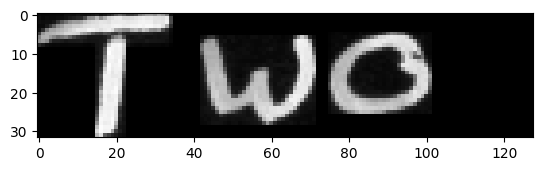



0riginal text =   men
Predicted text = men

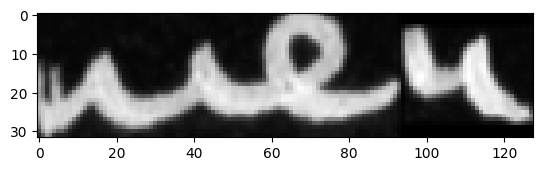



0riginal text =   who
Predicted text = who

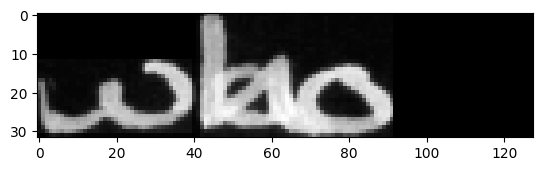



0riginal text =   are
Predicted text = are

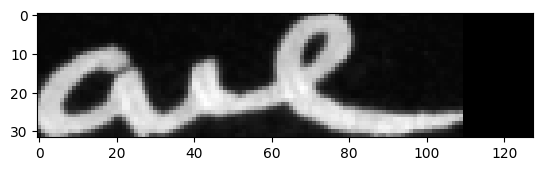



0riginal text =   poles
Predicted text = poles

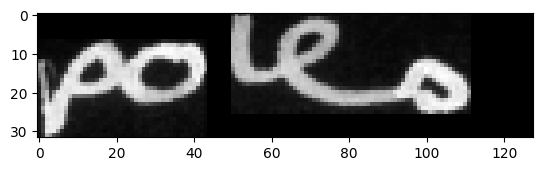



0riginal text =   apart
Predicted text = aort

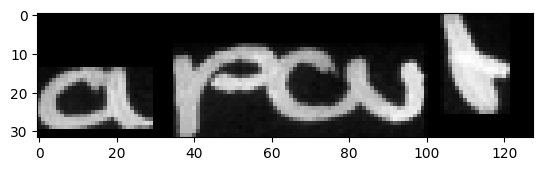



0riginal text =   in
Predicted text = in

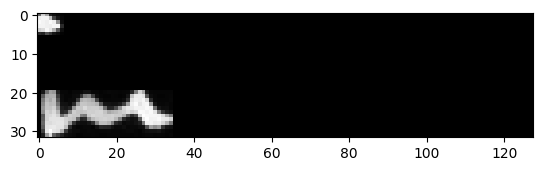



0riginal text =   last
Predicted text = last

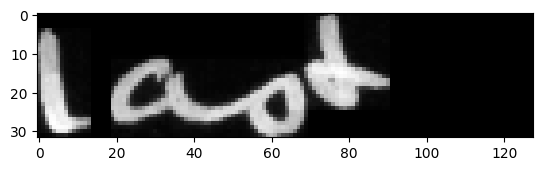



0riginal text =   night
Predicted text = night

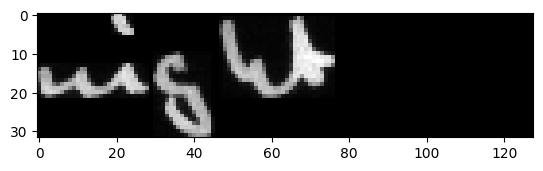



0riginal text =   dominated
Predicted text = demincted

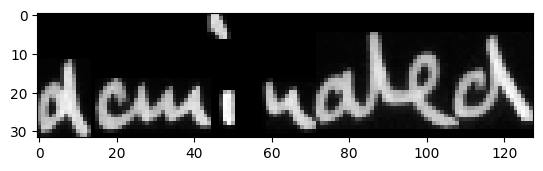



0riginal text =   Mr.
Predicted text = Mr.

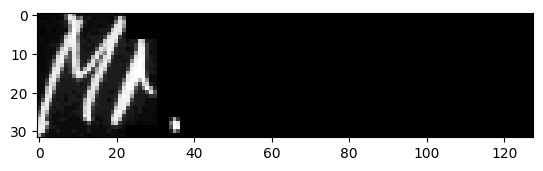



0riginal text =   Brown
Predicted text = Brown

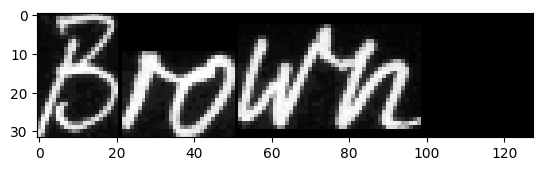



0riginal text =   ,
Predicted text = ,

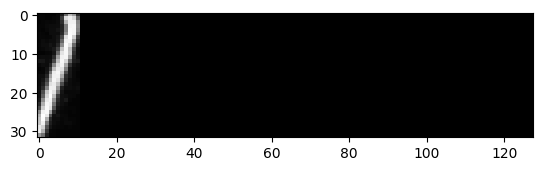



0riginal text =   passionate
Predicted text = pemiouate

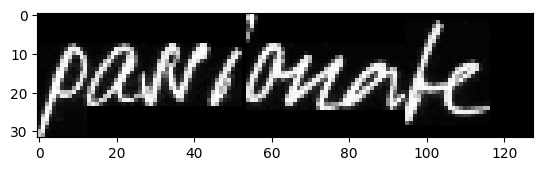



0riginal text =   and
Predicted text = and

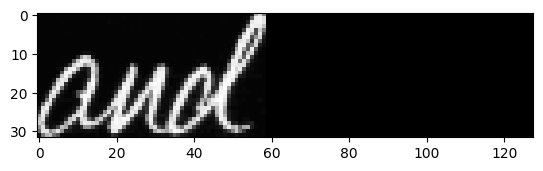



0riginal text =   warm-hearted
Predicted text = mom-tcate

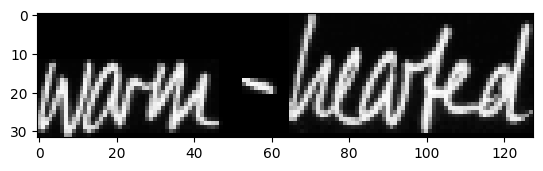



0riginal text =   led
Predicted text = led

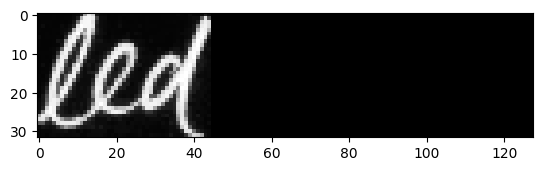



0riginal text =   Labour's
Predicted text = Laboure

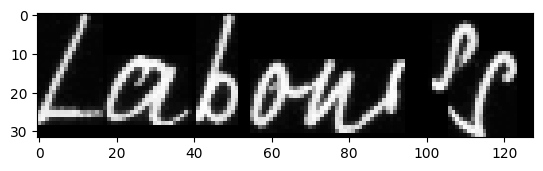



0riginal text =   attack
Predicted text = attack

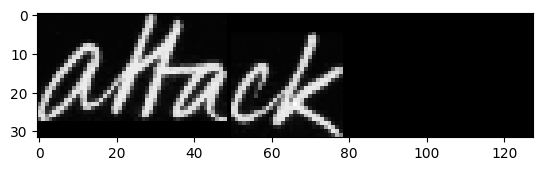



0riginal text =   on
Predicted text = on

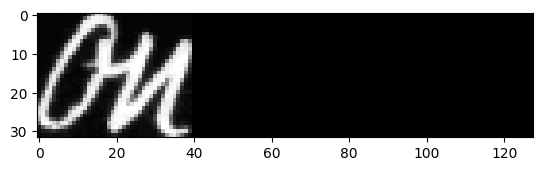



0riginal text =   the
Predicted text = the

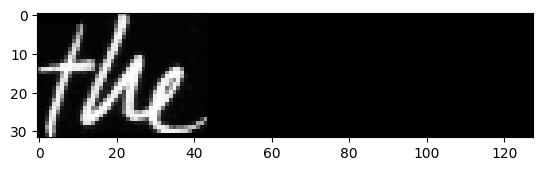



0riginal text =   higher
Predicted text = higher

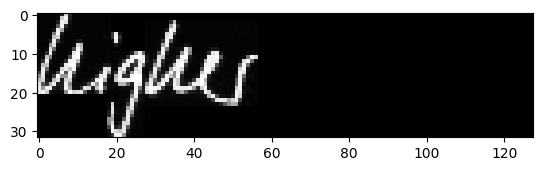



0riginal text =   health
Predicted text = healtkk

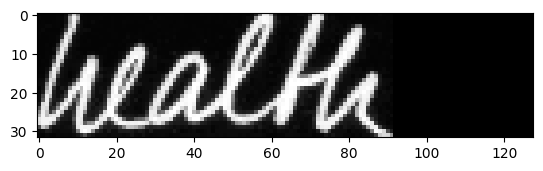



0riginal text =   charges
Predicted text = chager

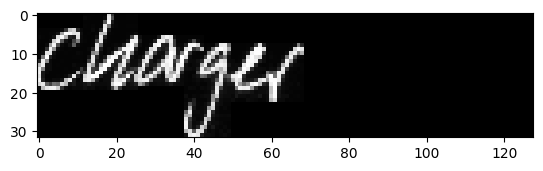



0riginal text =   .
Predicted text = .

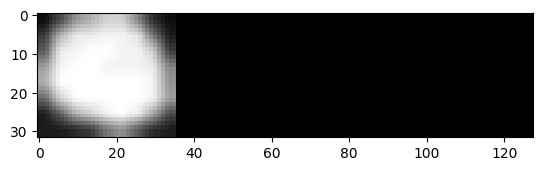



0riginal text =   Powell
Predicted text = Pomell

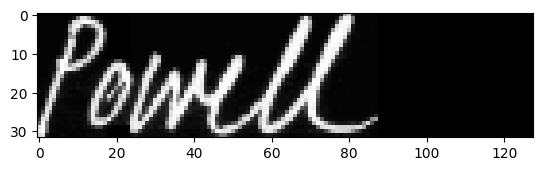



0riginal text =   ,
Predicted text = ,

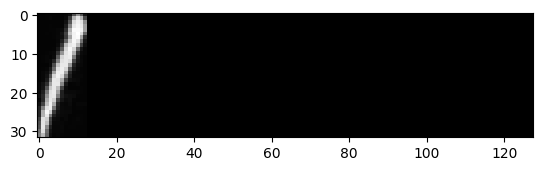



0riginal text =   white-faced
Predicted text = white-fared

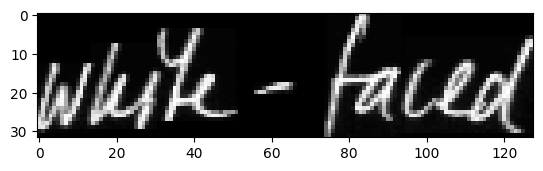



0riginal text =   and
Predicted text = and

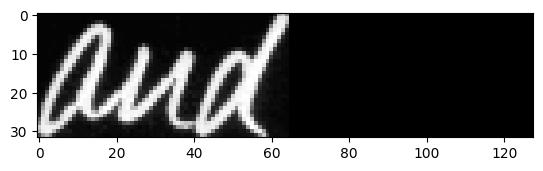



0riginal text =   outwardly
Predicted text = cutmteadly

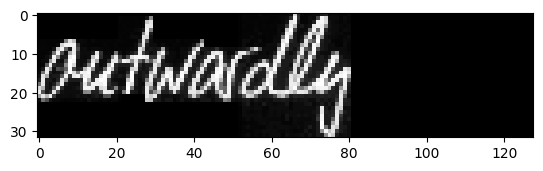



0riginal text =   unemotional
Predicted text = uumotional

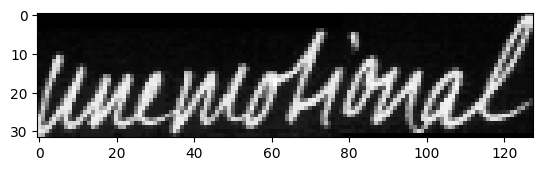



0riginal text =   ,
Predicted text = ,

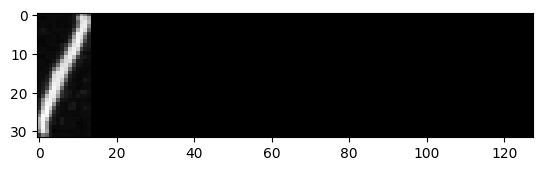



0riginal text =   replied
Predicted text = realied

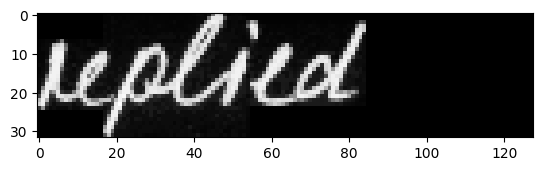



0riginal text =   with
Predicted text = with

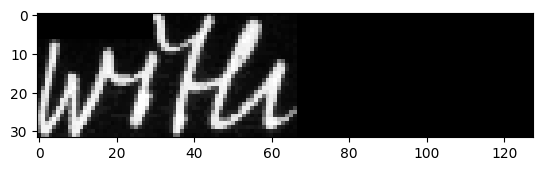



0riginal text =   statistical
Predicted text = ptatitical

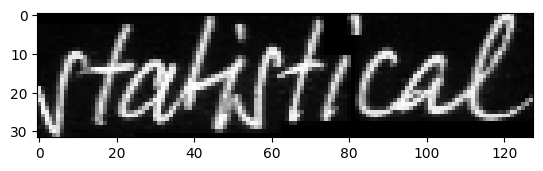



0riginal text =   state-
Predicted text = wtake-

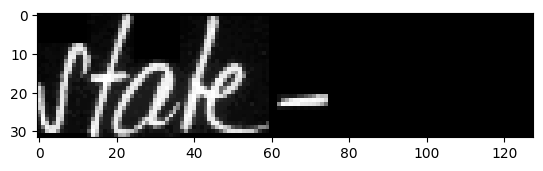



0riginal text =   ment
Predicted text = ment

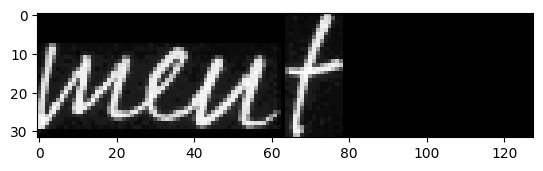



0riginal text =   -
Predicted text = -

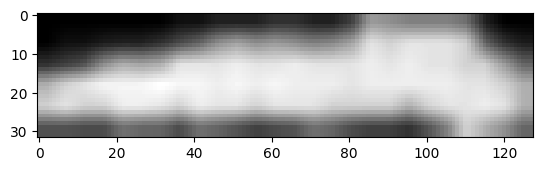



0riginal text =   and
Predicted text = and

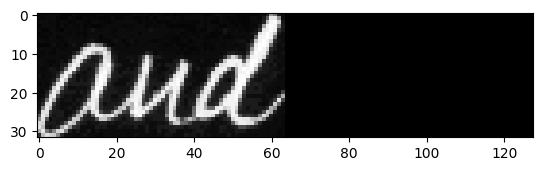



0riginal text =   ended
Predicted text = nnded

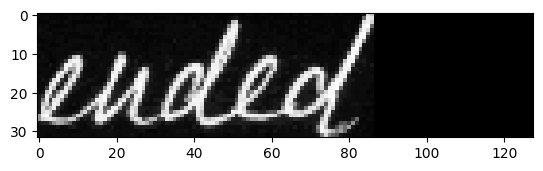



0riginal text =   by
Predicted text = by

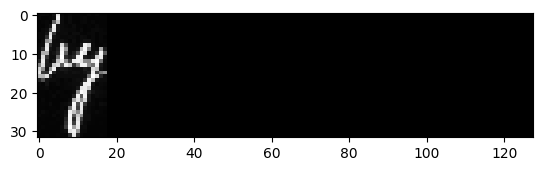



0riginal text =   inciting
Predicted text = inciting

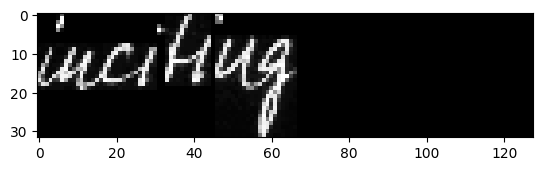



0riginal text =   Labour
Predicted text = dabou

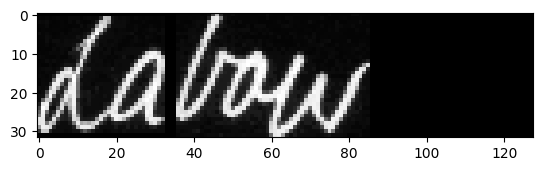



0riginal text =   to
Predicted text = to

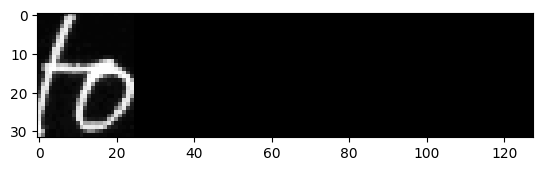



0riginal text =   angry
Predicted text = anery

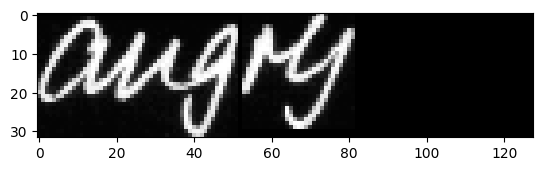



0riginal text =   uproar
Predicted text = upreer

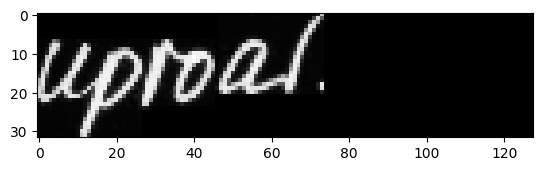



0riginal text =   .
Predicted text = .

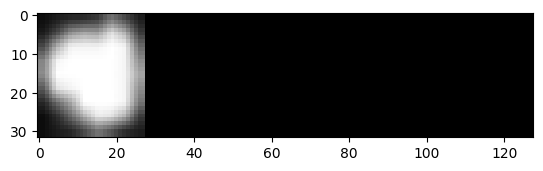



0riginal text =   One
Predicted text = One

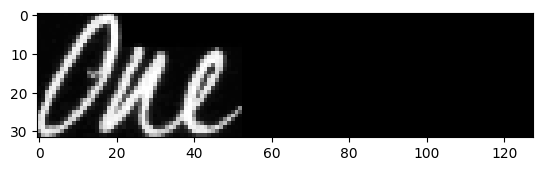



0riginal text =   dealt
Predicted text = dealt

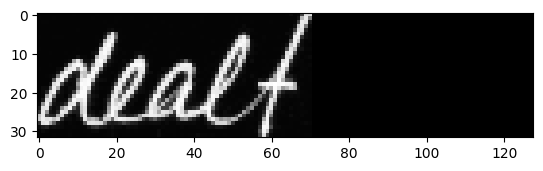



0riginal text =   with
Predicted text = with

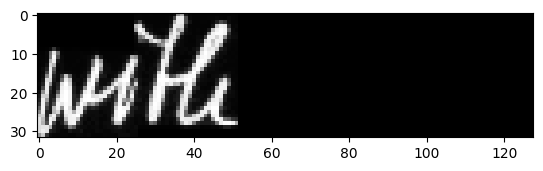



0riginal text =   the
Predicted text = the

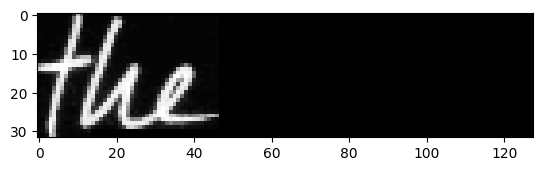



0riginal text =   human
Predicted text = mmman

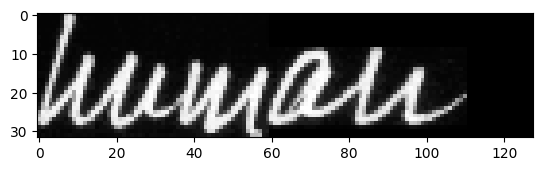



0riginal text =   behind
Predicted text = behind

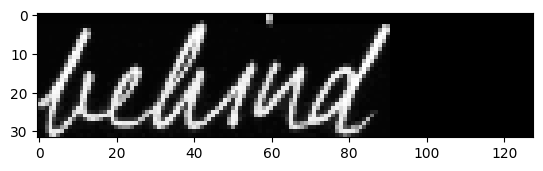



0riginal text =   the
Predicted text = the

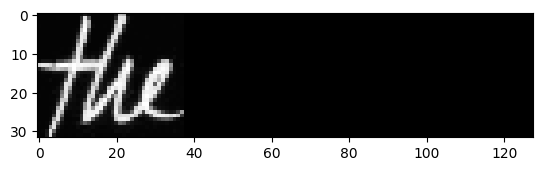



0riginal text =   Health
Predicted text = Health

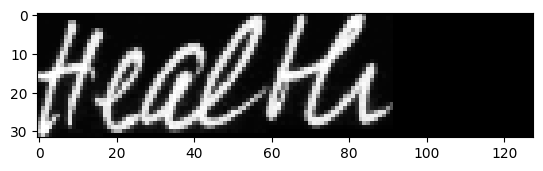



0riginal text =   Service
Predicted text = Sevice

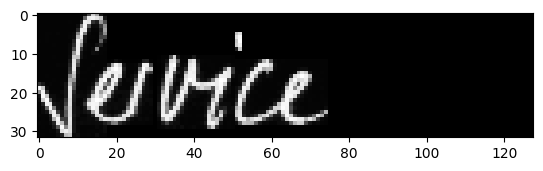



0riginal text =   ;
Predicted text = :

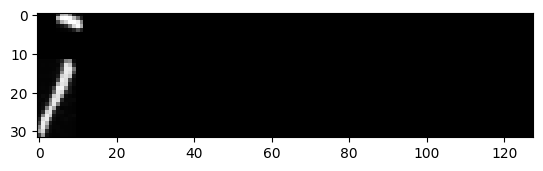



0riginal text =   the
Predicted text = the

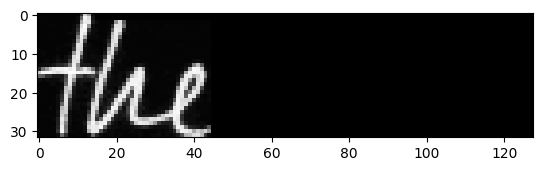



0riginal text =   other
Predicted text = other

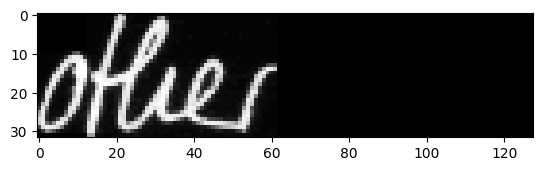



0riginal text =   always
Predicted text = alnany

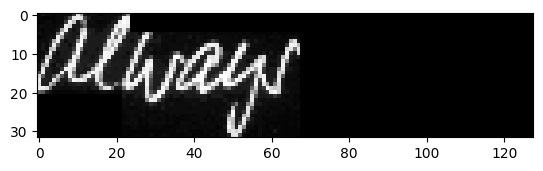



0riginal text =   come
Predicted text = came

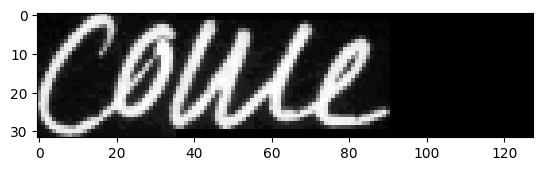



0riginal text =   first
Predicted text = fist

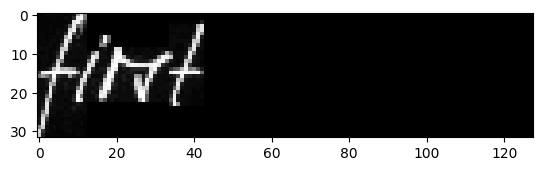



0riginal text =   .
Predicted text = .

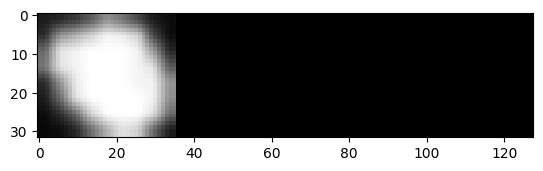



0riginal text =   Mr.
Predicted text = Mr.

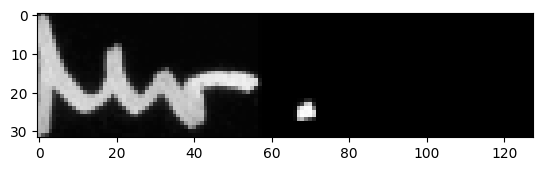



0riginal text =   ,
Predicted text = ,

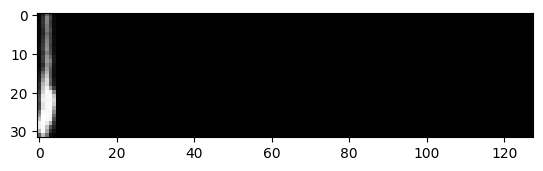



0riginal text =   passionate
Predicted text = passioncte

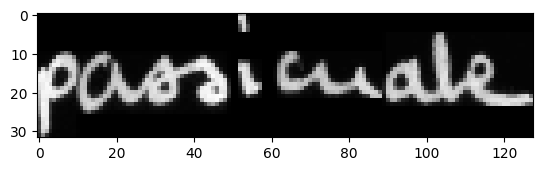



0riginal text =   and
Predicted text = and

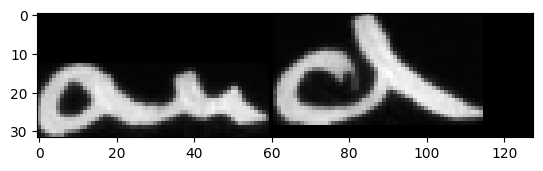



0riginal text =   warm-hearted
Predicted text = mrmm-laited

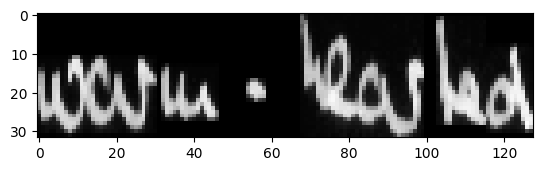



0riginal text =   ,
Predicted text = ,

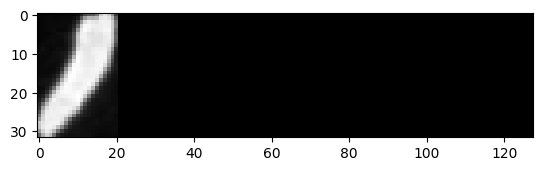



0riginal text =   led
Predicted text = lesd

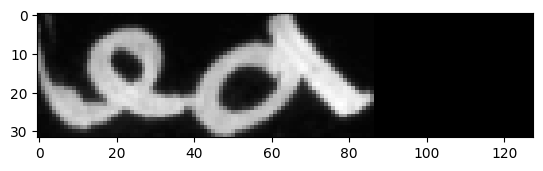



0riginal text =   Labour's
Predicted text = Laboyr's

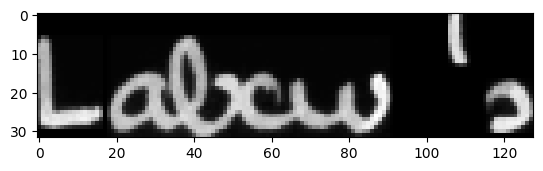



0riginal text =   attack
Predicted text = attack

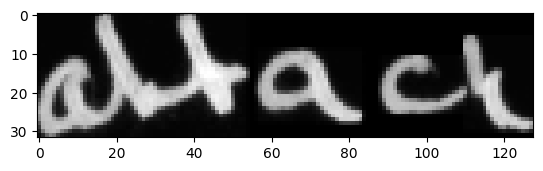



0riginal text =   on
Predicted text = or

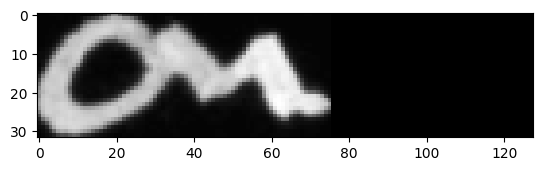



0riginal text =   higher
Predicted text = mgher

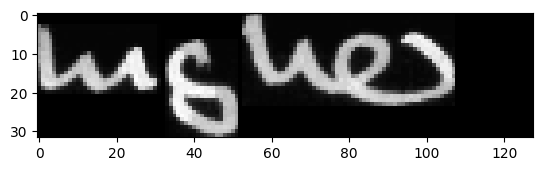



0riginal text =   health
Predicted text = health

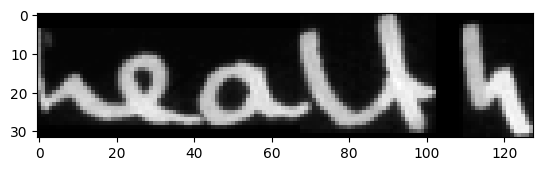



0riginal text =   charges
Predicted text = chalges

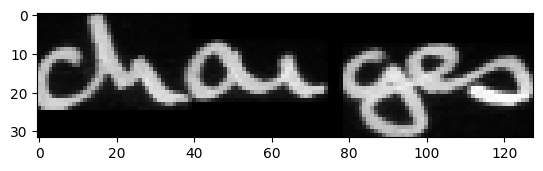



0riginal text =   .
Predicted text = .

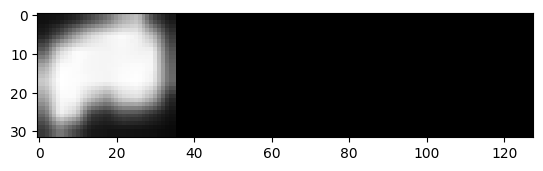



0riginal text =   Mr.
Predicted text = Mr.

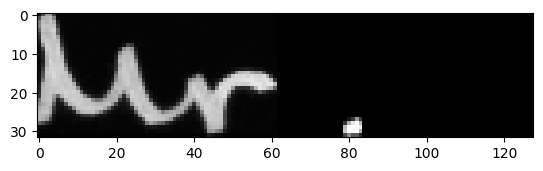



0riginal text =   Powell
Predicted text = Powell

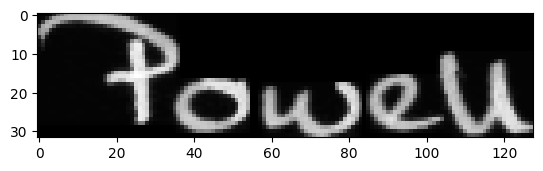



0riginal text =   ,
Predicted text = ,

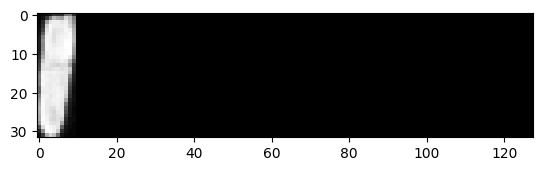



0riginal text =   white-faced
Predicted text = dice-faced

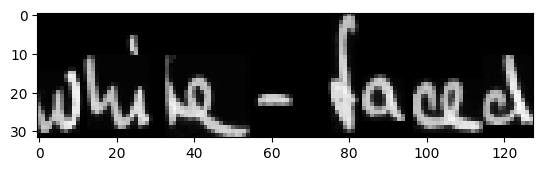



0riginal text =   and
Predicted text = and

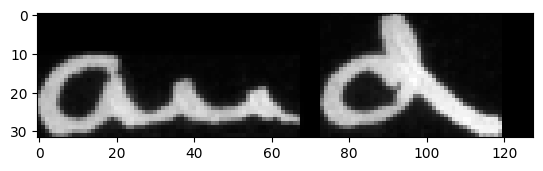



0riginal text =   unemotional
Predicted text = mnumstional

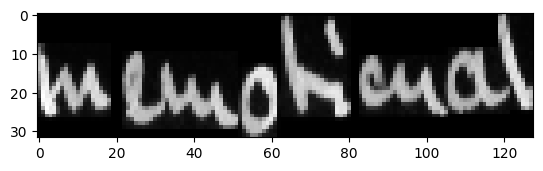



0riginal text =   ,
Predicted text = ,

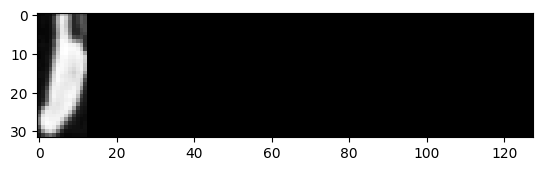



0riginal text =   replied
Predicted text = replied

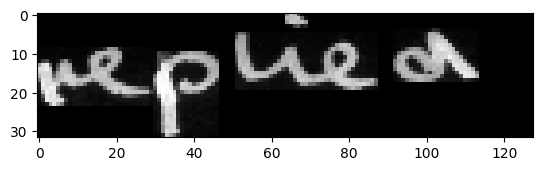



0riginal text =   with
Predicted text = with

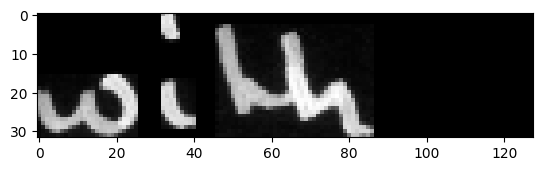



0riginal text =   a
Predicted text = a

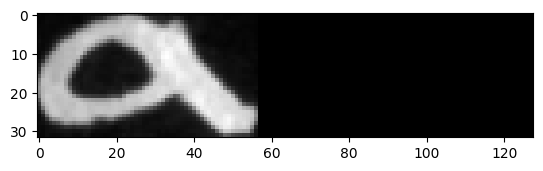



0riginal text =   statistical
Predicted text = datistical

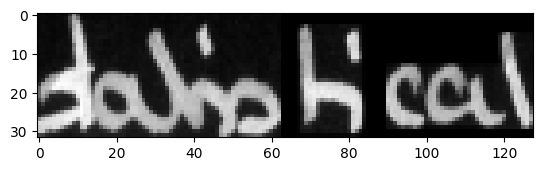



0riginal text =   statement
Predicted text = statement

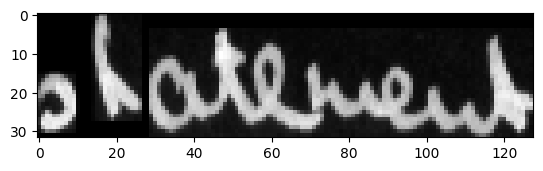



0riginal text =   -
Predicted text = -

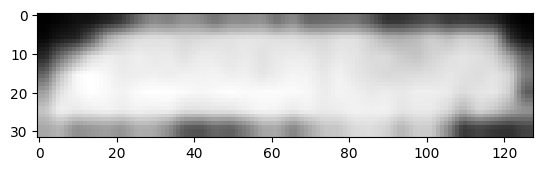



0riginal text =   and
Predicted text = and

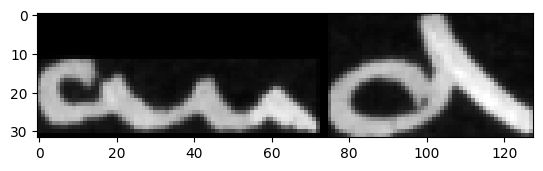



0riginal text =   by
Predicted text = by

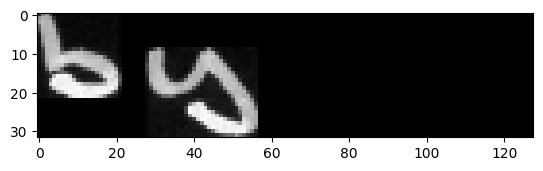



0riginal text =   inciting
Predicted text = incitarg

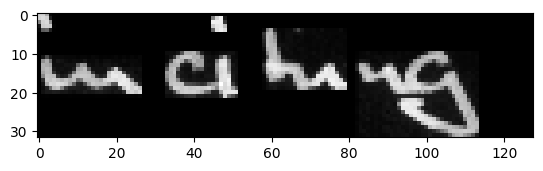



0riginal text =   Labour
Predicted text = laborr

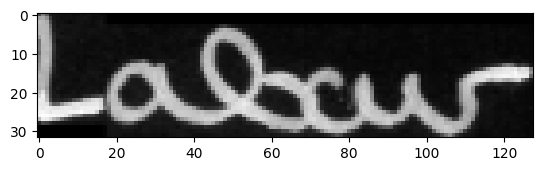



0riginal text =   MPs
Predicted text = MPs

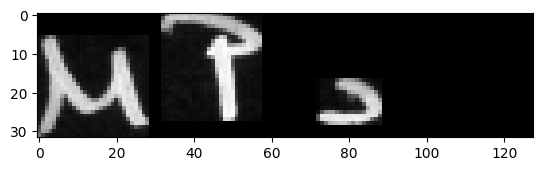



0riginal text =   to
Predicted text = to

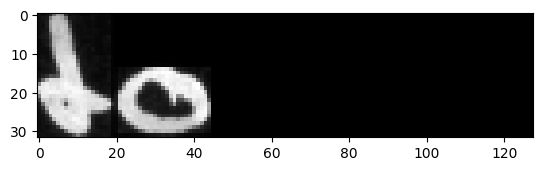



0riginal text =   angry
Predicted text = anory

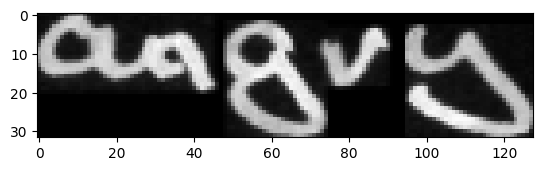



0riginal text =   uproar
Predicted text = wproer

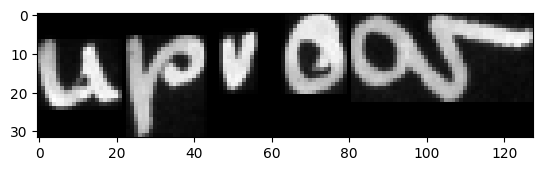



0riginal text =   .
Predicted text = .

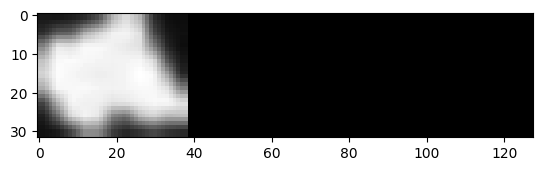



0riginal text =   One
Predicted text = One

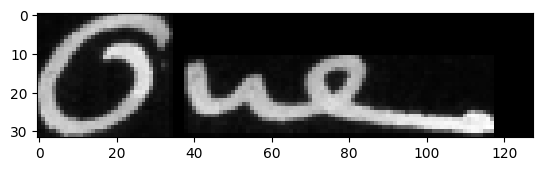



0riginal text =   with
Predicted text = with

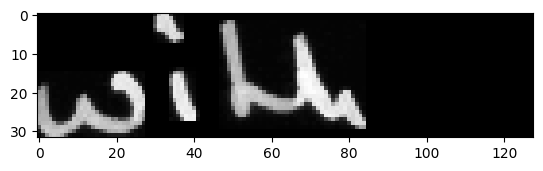



0riginal text =   the
Predicted text = the

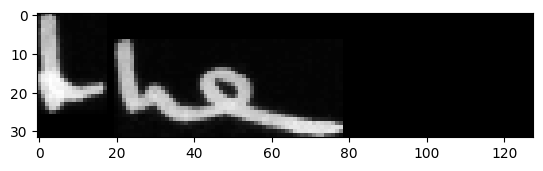



0riginal text =   human
Predicted text = hmman

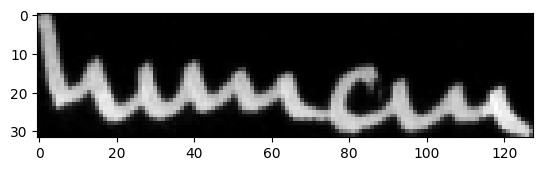



0riginal text =   issue
Predicted text = issue

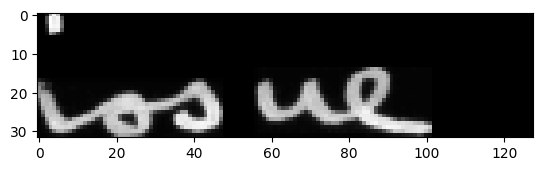



0riginal text =   behind
Predicted text = behind

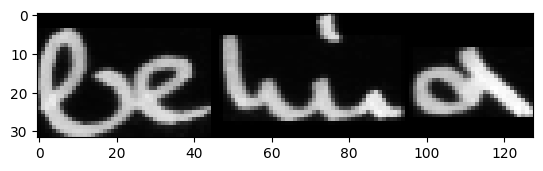



0riginal text =   the
Predicted text = the

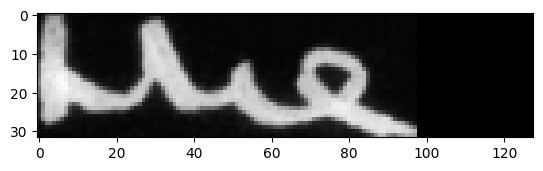



0riginal text =   Health
Predicted text = Health

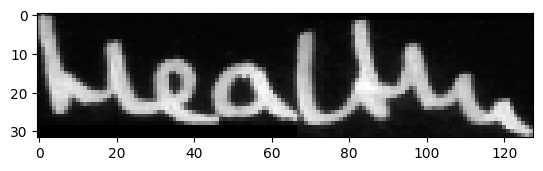



0riginal text =   Service
Predicted text = service

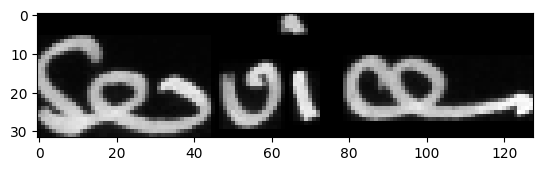



0riginal text =   ;
Predicted text = :

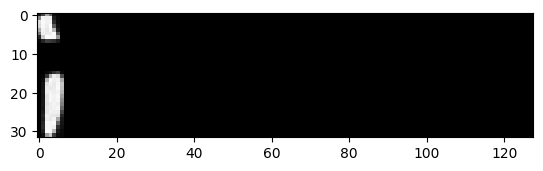



0riginal text =   other
Predicted text = other

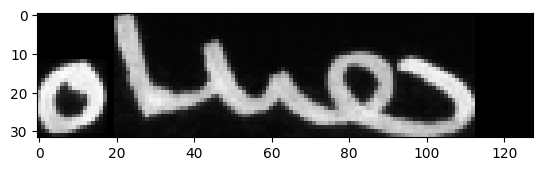



0riginal text =   tried
Predicted text = tied

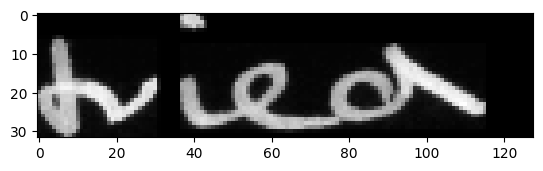



0riginal text =   to
Predicted text = to

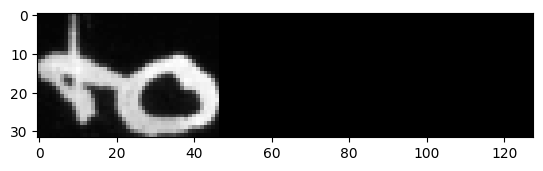



0riginal text =   show
Predicted text = shoy

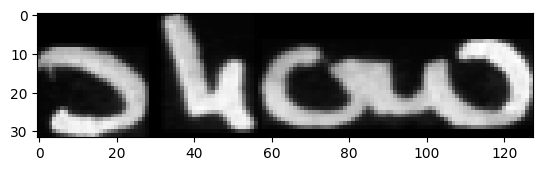



0riginal text =   that
Predicted text = that

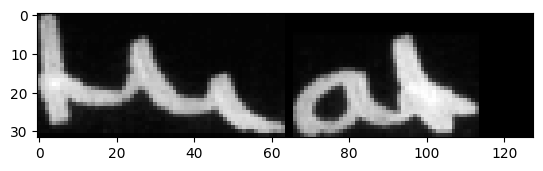



0riginal text =   the
Predicted text = the

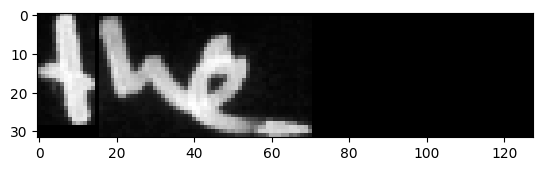



0riginal text =   balance-sheet
Predicted text = calace-steet

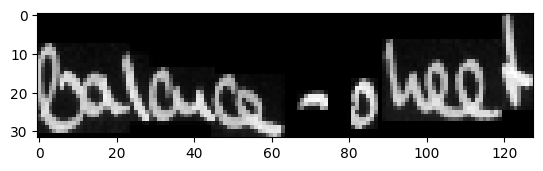



0riginal text =   must
Predicted text = mot

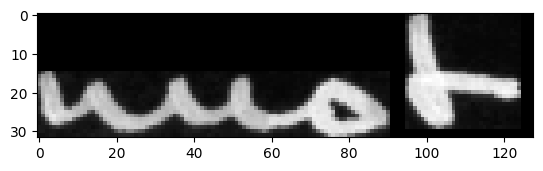



0riginal text =   always
Predicted text = always

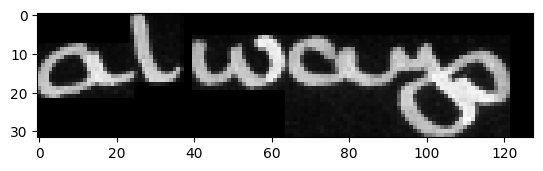



0riginal text =   first
Predicted text = firsr

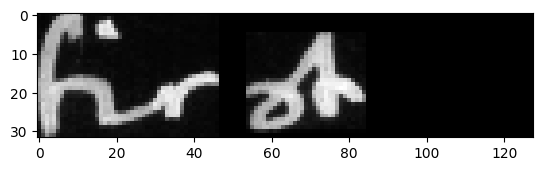



0riginal text =   .
Predicted text = .

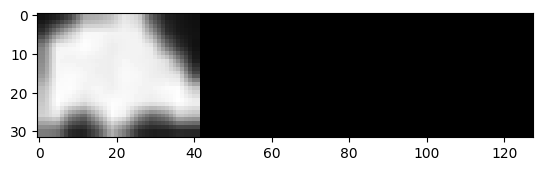



0riginal text =   The
Predicted text = The

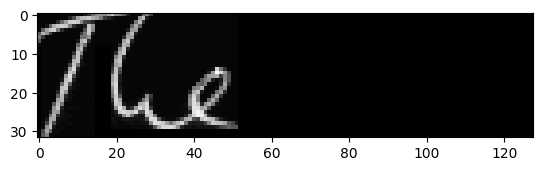



0riginal text =   result
Predicted text = wull

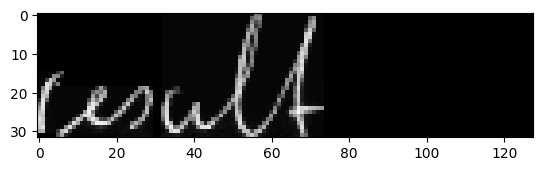



0riginal text =   of
Predicted text = of

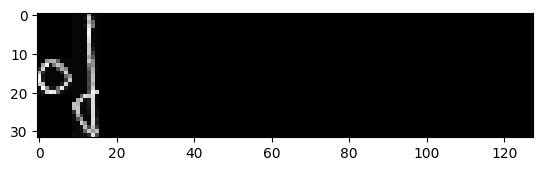



0riginal text =   the
Predicted text = the

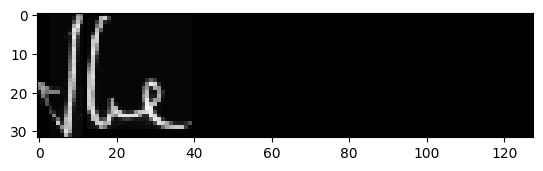



0riginal text =   vote
Predicted text = uote

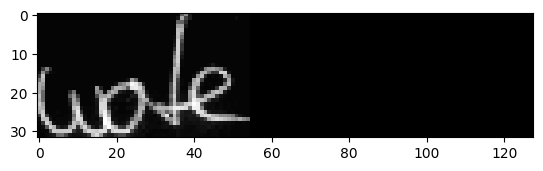



0riginal text =   was
Predicted text = was

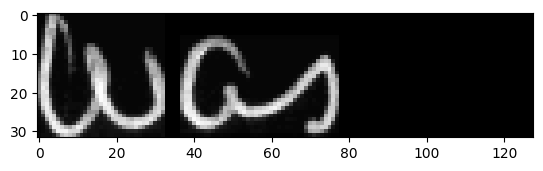



0riginal text =   not
Predicted text = not

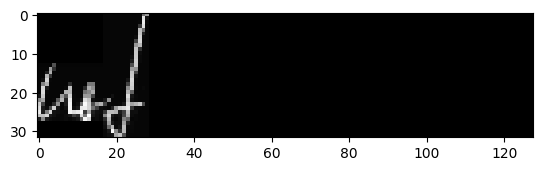



0riginal text =   doubt
Predicted text = doubl

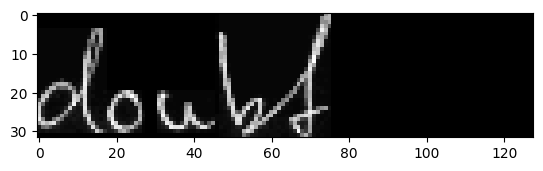



0riginal text =   .
Predicted text = .

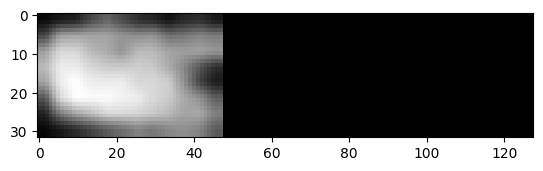



0riginal text =   For
Predicted text = Tol

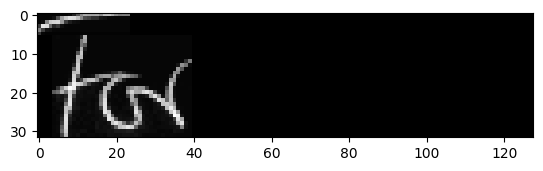



0riginal text =   the
Predicted text = the

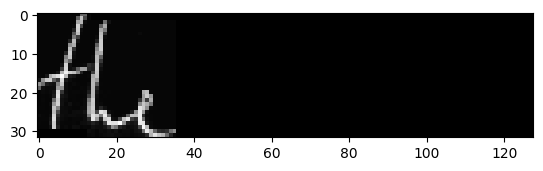



0riginal text =   Tories
Predicted text = Taries

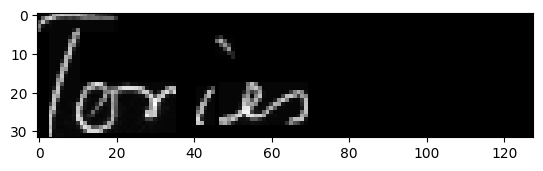



0riginal text =   were
Predicted text = wrre

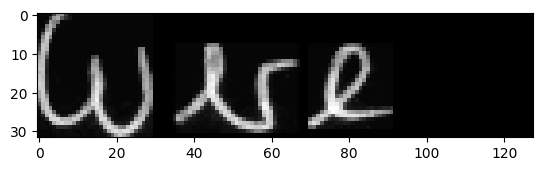



0riginal text =   massed
Predicted text = masved

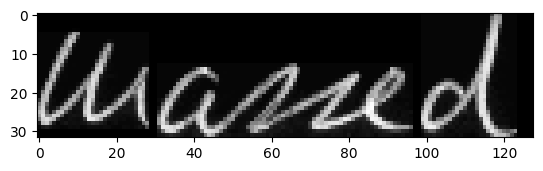



0riginal text =   in
Predicted text = in

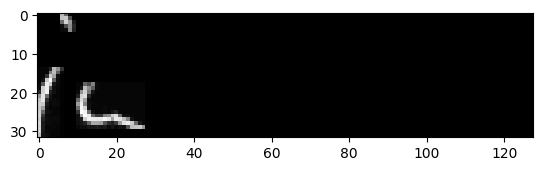



0riginal text =   answer
Predicted text = answer

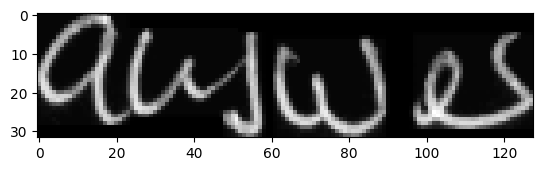



0riginal text =   their
Predicted text = their

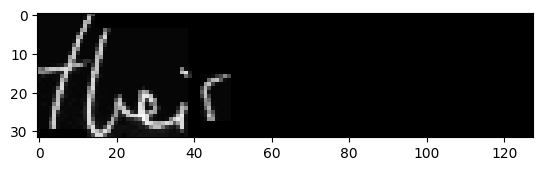



0riginal text =   whips
Predicted text = aohin

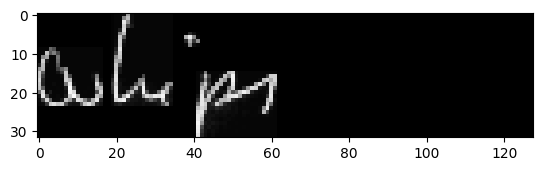



0riginal text =   to
Predicted text = to

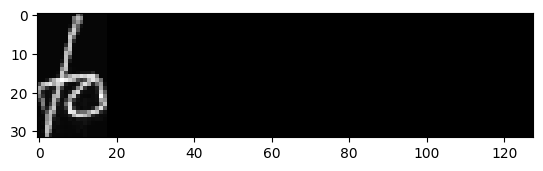



0riginal text =   defeat
Predicted text = defet

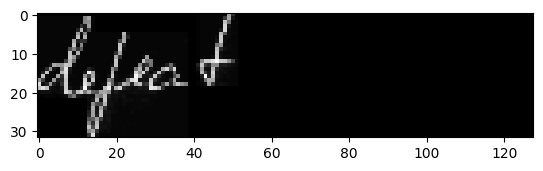



0riginal text =   a
Predicted text = a

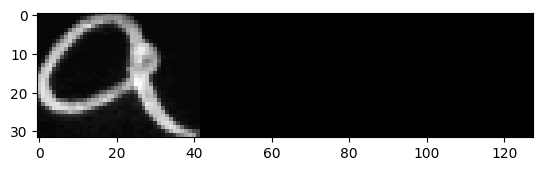



0riginal text =   censure
Predicted text = cenwre

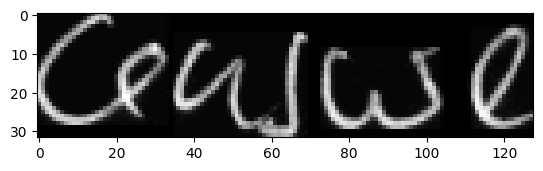



0riginal text =   motion
Predicted text = motion

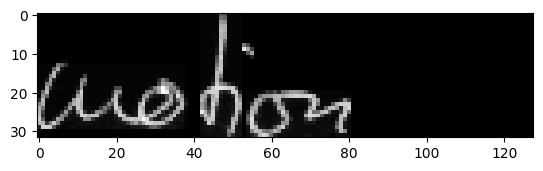



0riginal text =   on
Predicted text = on

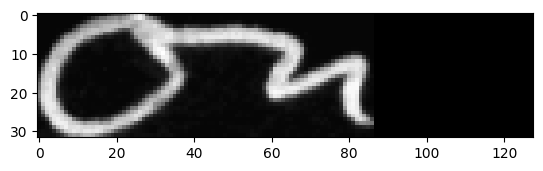



0riginal text =   the
Predicted text = the

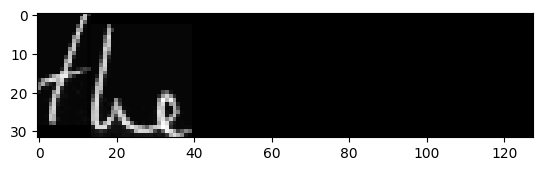



0riginal text =   for
Predicted text = for

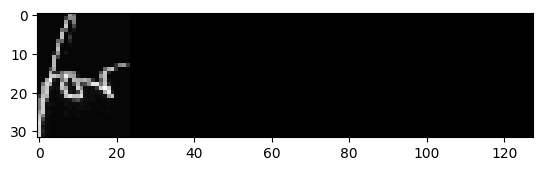



0riginal text =   "
Predicted text = "

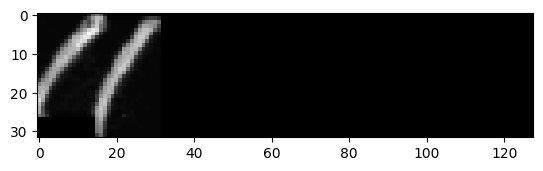



0riginal text =   undermining
Predicted text = unnlermining

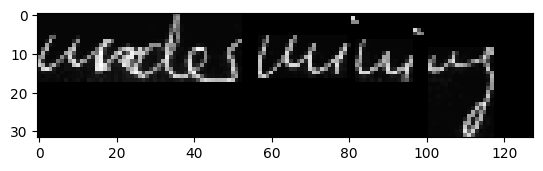

In [ ]:
# predict outputs on validation images
prediction = act_model.predict(train_images[2500:2700])

# use CTC decoder
decoded = K.ctc_decode(prediction,
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]

out = K.get_value(decoded)

# see the results
for i, x in enumerate(out):
    print("0riginal text =  ", train_original_text[2500+i])
    print("Predicted text = ", end = '')
    for p in x:
        if int(p) != -1:
            print(char_list[int(p)], end = '')
    plt.imshow(train_images[2500+i].reshape(32,128), cmap=plt.cm.gray)
    plt.show()
    print('\n')

## Plot accuracy and loss


### Epcoh = 30

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)

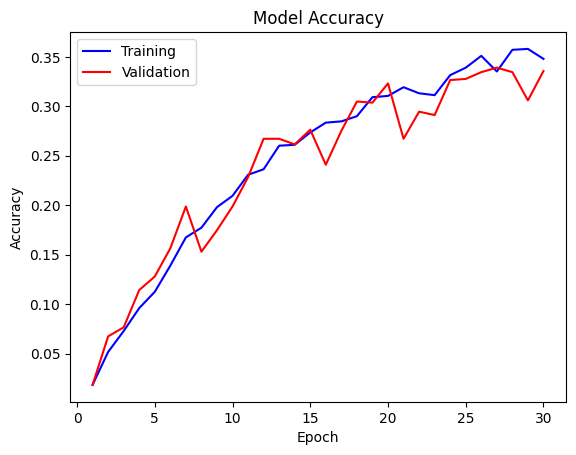

In [ ]:
## Model accuracy plot
plt.plot(epochs, accuracy, 'b')
plt.plot(epochs, val_accuracy, 'r')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

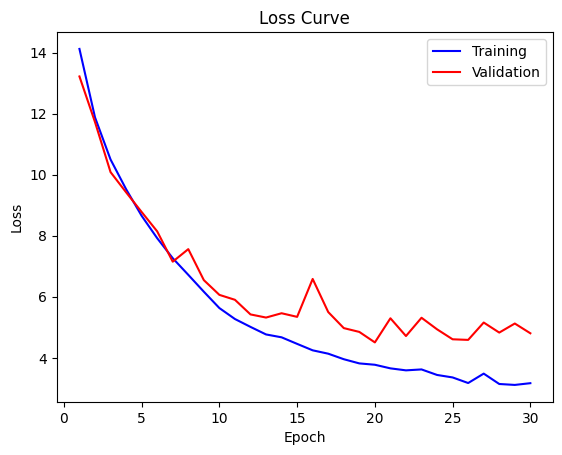

In [ ]:
## loss curve plot
plt.plot(epochs, loss, 'b')
plt.plot(epochs, val_loss, 'r')
plt.title('Loss Curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

### Epoch = 20

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)

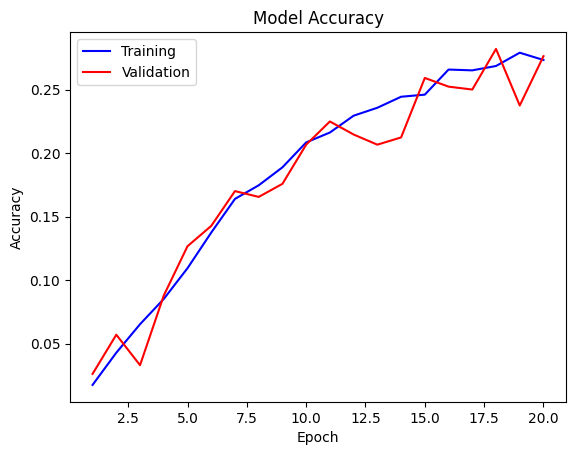

In [ ]:
## Model accuracy plot
plt.plot(epochs, accuracy, 'b')
plt.plot(epochs, val_accuracy, 'r')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (1,) and (20,)

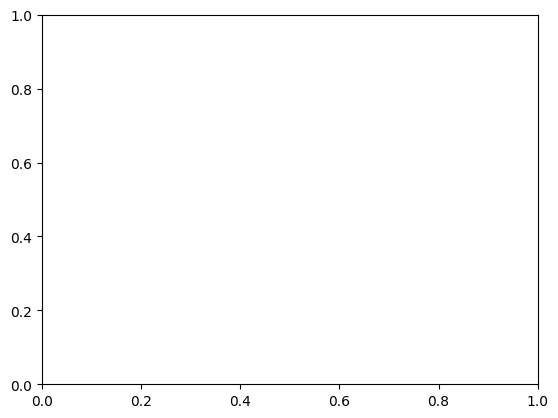

In [ ]:
## loss curve plot
plt.plot(epochs, loss, 'b')
plt.plot(epochs, val_loss, 'r')
plt.title('Loss Curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()